In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 19 July 2024

# using mask of longitudinal-bins created by 
# - WAOM10extend_shflim_S_0.25Q_OHB_shelf_budget_closure.ipynb
# to integrated over regions.
# Using mask for cont. shelf, land and ice shelf cavities, we
# can separate the heat tendency in each region due to individual
# processes (e.g. advection, diffusion, sfc fluxes)

## loading saved netcdf with each component of RHS heat budget eqn., 
# integrated horizontally & vertically.
# 
#waom_notebook/OHB_shelf/OHB_closure/WAOM10_OHB_[hadv/vadv/hdiff/viff]_regional_using_lon_masks[].py_iceshelf
# _iceshelf refers to only int. within ice shelf cavities of each subsector


In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw
import cmocean

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:41389' processes=28 threads=28>


In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/'

In [5]:
  %%time
    
    # using xr.open_mfdataset
    
    vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]
    
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

    m = ds.variables["m"]
    time_avg = ds.variables["ocean_time"] 
    ice_draft = ds.variables["zice"]
    
    mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
    mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
    
    print("Vtransform=2")
    #  New formulation (Vtransform(ng) = 2):
    #
    #         z_w(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo_w
    #                 Zo_w = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]
    hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
    z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho 
    
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
    z_w = ds.zeta + (ds.zeta + hwater) * Zo_w 
    
    dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
    
    lat_rho = dg.variables["lat_rho"]
    lon_rho = dg.variables["lon_rho"]
    lat_u = dg.variables["lat_u"]
    lon_u = dg.variables["lon_u"]
    lat_v = dg.variables["lat_v"]
    lon_v = dg.variables["lon_v"]
    pm = dg.variables["pm"]
    pn = dg.variables["pn"]
    h = dg.variables["h"]
    zice = dg.variables["zice"]
    
    ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
    ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset
    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    
    ds.close()
    dg.close()
    
    # calculate surface sigma_theta (potential density)
    # sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000
    area=np.divide(1,pm*pn)

    Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
    print(z_w.shape, Z_w.shape)
    dz = np.diff(Z_w,axis=1)

Vtransform=2
(365, 560, 630, 32) (365, 32, 560, 630)
CPU times: user 1min 26s, sys: 1min 25s, total: 2min 51s
Wall time: 3min 3s


In [6]:
    # load horizontal diffusion of heat calculated online:
    	# float temp_hdiff(ocean_time, s_rho, eta_rho, xi_rho) ;
    
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_dia_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
    temp_hdiff = ds.temp_hdiff
    temp_vdiff = ds.temp_vdiff
    temp_hadv = ds.temp_hadv
    temp_vadv = ds.temp_vadv
    ds.close()

In [7]:
    # DIA 5-daily:
    
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_dia_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
    temp_hdiff_5d = ds.temp_hdiff
    temp_vdiff_5d = ds.temp_vdiff
    temp_hadv_5d = ds.temp_hadv
    temp_vadv_5d = ds.temp_vadv
    ds.close()

    # load dz 5 daily too:
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
    hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
    z_w_5d = ds.zeta + (ds.zeta + hwater) * Zo_w 
    ds.close()

    Z_w_5d = z_w_5d.transpose('ocean_time','s_w','eta_rho','xi_rho')
    dz_5d = np.diff(Z_w_5d,axis=1)

In [8]:
print(dz.shape)#, dz_5d.shape)

(365, 31, 560, 630)


In [9]:
    # convert dz to xarray:
    months=np.arange(0,365)*(1/30.41667)
    # save to netcdf file:
    coordinatesC=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)), eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))
    
    dz_xr = xr.DataArray(dz, coords = coordinatesC, dims = ['ocean_time','s_rho','eta_rho','xi_rho'])

In [10]:
    months2=np.arange(0,73)*(5/30.41667)
    # save to netcdf file:
    coordinatesC2=dict(ocean_time=months2, s_rho=(['s_rho'], np.arange(0,31)), eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))
    
    dz_5d_xr = xr.DataArray(dz_5d, coords = coordinatesC2, dims = ['ocean_time','s_rho','eta_rho','xi_rho'])


In [11]:
# load contour (1500m/calving-front):
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
contour_masked_above_CF = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)

In [12]:
mask_shelf = ma.masked_where(contour_masked_above==-1000, np.ones(h.shape))
mask_iceshelf = ma.masked_where(contour_masked_above_CF!=-1000, np.ones(h.shape))
mask_outiceshelf = ma.masked_where(contour_masked_above_CF==-1000, np.ones(h.shape))

mask_land = ma.masked_where(h<=40, np.ones(h.shape))


In [13]:
area_sum = area.sum('eta_rho').sum('xi_rho')

In [14]:
# define constants:
rho0=1035
Cp=3992.1
# Tf = -1.95 # degC
Tf =  -3.534879684448242

In [15]:
# load masks

dm = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/WAOM10_masked_lonBins.nc')
mask_LonBins = dm.variables['__xarray_dataarray_variable__']
dm.close()


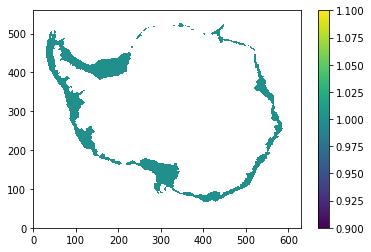

In [16]:
plt.pcolormesh(mask_shelf*mask_iceshelf)
plt.colorbar()

In [17]:
len(mask_LonBins)

120

In [18]:
# Define conditions to mask out (1) off the shelf, (2) land (see plots above)
# PS: condtions used for the OHB closure (ice shelf front contour doesn't matter)
#condition1 = contour_masked_above == -1000
#condition2 = (zice+h) <= 1

# Combine conditions with logical OR
#combined_condition = condition1 | condition2

# here I need the ice shelf mask obtained from the contour:
# define condition:
lonbin = 0
comb_masks = mask_LonBins[lonbin]*mask_shelf*mask_land
condition1 = comb_masks != 1


In [19]:
mask_LonBins

<xarray.Variable (time: 120, y: 560, x: 630)>
[42336000 values with dtype=float64]

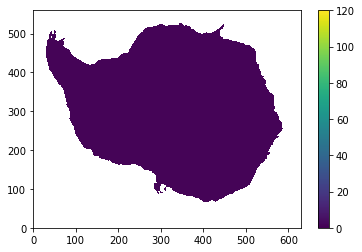

In [20]:
# plt.pcolormesh(mask_LonBins[0:50].sum('time')*mask_shelf) # cont. shelf + ice shelf cavitiess
for ll in range(120):
    plt.pcolormesh(mask_LonBins[ll,:]*mask_shelf, vmin=0, vmax=120) # only cont. shelf
    # plt.pcolormesh(comb_masks)
plt.colorbar()


In [21]:
# temp_hadv[0,0,:].shape
tst = ma.masked_where(condition1, temp_hadv[0,0,:])

(50.0, 250.0)

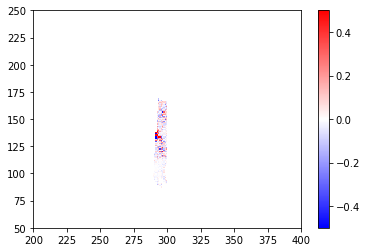

In [22]:
plt.pcolormesh(tst*mask_iceshelf*1e5,vmin=-.5,vmax=.5,cmap='bwr')
plt.colorbar()
plt.xlim(200,400)
plt.ylim(50,250)

### load pre-saved heat budget components

In [23]:
file = files_path + "WAOM10_OHB_lonbins_temp_hadv_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hadv = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_hdiff_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hdiff = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vadv_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vadv = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vdiff_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vdiff = ds.variables['__xarray_dataarray_variable__']
ds.close()

In [24]:
file = files_path + "WAOM10_OHB_lonbins_temp_hadv_vint_5daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hadv_5d = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_hdiff_vint_5daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hdiff_5d = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vadv_vint_5daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vadv_5d = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vdiff_vint_5daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vdiff_5d = ds.variables['__xarray_dataarray_variable__']
ds.close()

In [25]:
file = files_path + "WAOM10_OHB_lonbins_temp_hadv_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hadv_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_hdiff_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hdiff_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vadv_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vadv_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vdiff_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vdiff_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

#### waom4

In [26]:
print(files_path+ "WAOM4_OHB_lonbins_temp_hadv_vint_daily.nc")

/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/WAOM4_OHB_lonbins_temp_hadv_vint_daily.nc


In [27]:
file = files_path + "WAOM4_OHB_lonbins_temp_hadv_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4_hadv = ds.variables['__xarray_dataarray_variable__']
w4_ocean_time = ds.ocean_time
w4_lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM4_OHB_lonbins_temp_hdiff_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4_hdiff = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_OHB_lonbins_temp_vadv_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4_vadv = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_OHB_lonbins_temp_vdiff_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4_vdiff = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_OHB_lonbins_temp_hadv_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4_hadv_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_OHB_lonbins_temp_hdiff_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4_hdiff_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_OHB_lonbins_temp_vadv_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4_vadv_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_OHB_lonbins_temp_vdiff_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4_vdiff_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

In [28]:
file = files_path + "WAOM4_notides_OHB_lonbins_temp_hadv_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4nt_hadv = ds.variables['__xarray_dataarray_variable__']
w4nt_ocean_time = ds.ocean_time
w4nt_lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM4_notides_OHB_lonbins_temp_hdiff_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4nt_hdiff = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_notides_OHB_lonbins_temp_vadv_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4nt_vadv = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_notides_OHB_lonbins_temp_vdiff_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4nt_vdiff = ds.variables['__xarray_dataarray_variable__']
ds.close()

### NEED TO CHANGE BACK TO _notides_ when it finish to re-run (2/8/24)
file = files_path + "WAOM4_notides_OHB_lonbins_temp_hadv_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4nt_hadv_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_notides_OHB_lonbins_temp_hdiff_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4nt_hdiff_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_notides_OHB_lonbins_temp_vadv_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4nt_vadv_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_notides_OHB_lonbins_temp_vdiff_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4nt_vdiff_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

### waom2

In [29]:
file = files_path + "WAOM2_OHB_lonbins_temp_hadv_vint_5daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w2_hadv = ds.variables['__xarray_dataarray_variable__']
w2_ocean_time = ds.ocean_time
w2_lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM2_OHB_lonbins_temp_hdiff_vint_5daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w2_hdiff = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM2_OHB_lonbins_temp_vadv_vint_5daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w2_vadv = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM2_OHB_lonbins_temp_vdiff_vint_5daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w2_vdiff = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM2_OHB_lonbins_temp_hadv_vint_5daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w2_hadv_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM2_OHB_lonbins_temp_hdiff_vint_5daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w2_hdiff_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM2_OHB_lonbins_temp_vadv_vint_5daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w2_vadv_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM2_OHB_lonbins_temp_vdiff_vint_5daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w2_vdiff_is = ds.variables['__xarray_dataarray_variable__']
ds.close()

In [30]:
# load basal melting

file = files_path + "WAOM10_OHB_lonbins_melt_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
bmelt = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_OHB_lonbins_melt_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4_bmelt = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM4_notides_OHB_lonbins_melt_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w4nt_bmelt = ds.variables['__xarray_dataarray_variable__']
ds.close()

file = files_path + "WAOM2_OHB_lonbins_melt_5daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
w2_bmelt = ds.variables['__xarray_dataarray_variable__']
ds.close()

In [31]:
net = hadv + vadv + hdiff + vdiff
net_is = hadv_is + vadv_is + hdiff_is + vdiff_is

w4_net = w4_hadv + w4_vadv + w4_hdiff + w4_vdiff
w4_net_is = w4_hadv_is + w4_vadv_is + w4_hdiff_is + w4_vdiff_is

w4nt_net = w4nt_hadv + w4nt_vadv + w4nt_hdiff + w4nt_vdiff
w4nt_net_is = w4nt_hadv_is + w4nt_vadv_is + w4nt_hdiff_is + w4nt_vdiff_is

w2_net = w2_hadv + w2_vadv + w2_hdiff + w2_vdiff
w2_net_is = w2_hadv_is + w2_vadv_is + w2_hdiff_is + w2_vdiff_is

net_5d = hadv_5d + vadv_5d + hdiff_5d +vdiff_5d


#### several simple plots to see what's the data looks like:

Text(0, 0.5, 'time (day)')

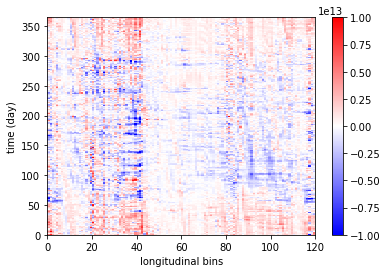

In [32]:
# plt.pcolormesh((net-net_is).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.pcolormesh((net).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.colorbar()
plt.xlabel('longitudinal bins')
plt.ylabel('time (day)')

Text(0, 0.5, 'time (day)')

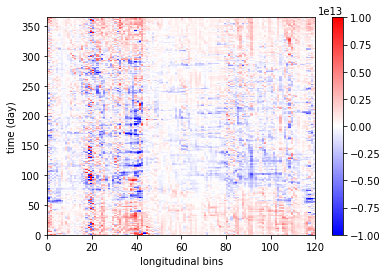

In [33]:
# plt.pcolormesh((w4_net-w4_net_is).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.pcolormesh((w4_net).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.colorbar()
plt.xlabel('longitudinal bins')
plt.ylabel('time (day)')

Text(0, 0.5, 'time (day)')

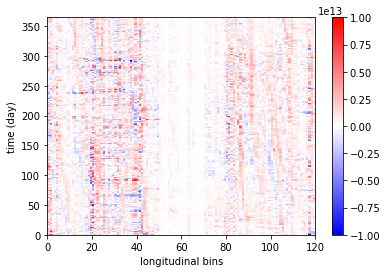

In [34]:
plt.pcolormesh((hadv-hadv_is+hdiff-hdiff_is).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
# plt.pcolormesh((hadv+hdiff).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.colorbar()
plt.xlabel('longitudinal bins')
plt.ylabel('time (day)')

Text(0, 0.5, 'time (day)')

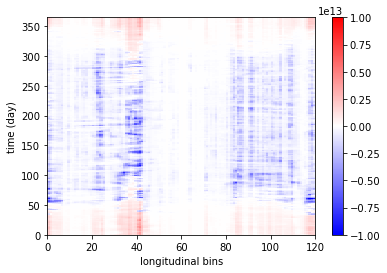

In [35]:
plt.pcolormesh((vadv-vadv_is+vdiff-vdiff_is).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
# plt.pcolormesh((vadv+vdiff).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.colorbar()
plt.xlabel('longitudinal bins')
plt.ylabel('time (day)')

Text(0.5, 1.0, 'WAOM10 (daily x 5-daily) OHB per sector vol-integ - annual mean \n cont. shelf + ice shelf cav.')

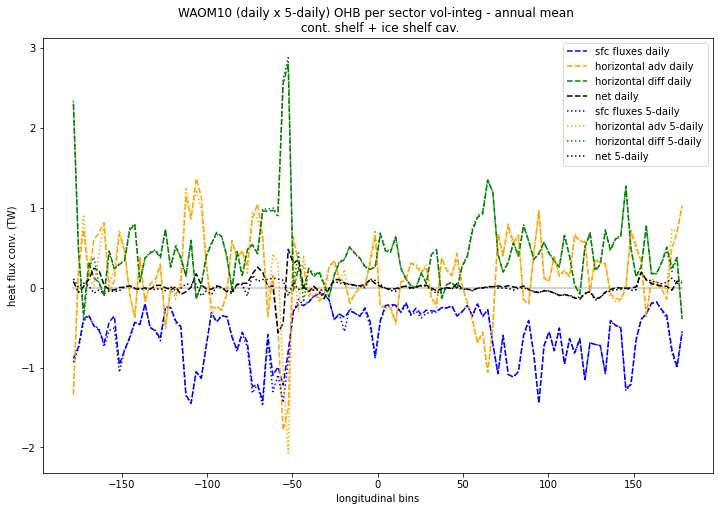

In [36]:
fig = plt.figure(figsize=(12,8))

plt.plot(lon_bins,(net)*0,'-',color='lightgray')
plt.plot(lon_bins,(vdiff).mean('ocean_time')*1e-12,'--',color='b',
         label='sfc fluxes daily')
plt.plot(lon_bins,(hadv).mean('ocean_time')*1e-12,'--',color='orange',
         label='horizontal adv daily')
plt.plot(lon_bins,(hdiff).mean('ocean_time')*1e-12,'--',color='green',
         label='horizontal diff daily')
plt.plot(lon_bins,(net).mean('ocean_time')*1e-12,'--',color='k',
         label='net daily')

plt.plot(lon_bins,(vdiff_5d).mean('ocean_time')*1e-12,':',color='b',
         label='sfc fluxes 5-daily')
plt.plot(lon_bins,(hadv_5d).mean('ocean_time')*1e-12,':',color='orange',
         label='horizontal adv 5-daily')
plt.plot(lon_bins,(hdiff_5d).mean('ocean_time')*1e-12,':',color='green',
         label='horizontal diff 5-daily')
plt.plot(lon_bins,(net_5d).mean('ocean_time')*1e-12,':',color='k',
         label='net 5-daily')

plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW)')
plt.title('WAOM10 (daily x 5-daily) OHB per sector vol-integ - annual mean \n cont. shelf + ice shelf cav.')

Comparison of the ocean heat budget annual averaged using 5-daily and daily diagnostics 
suggest non-negligible differences. While looking at individual processes, the differences
don't look too substantial, but the net tendency carry some differences at places, in special
the Ross and West Ant. sectors

Text(0.5, 1.0, 'WAOM10x4 OHB per sector vol-integ - annual mean \n cont. shelf + ice shelf cav.')

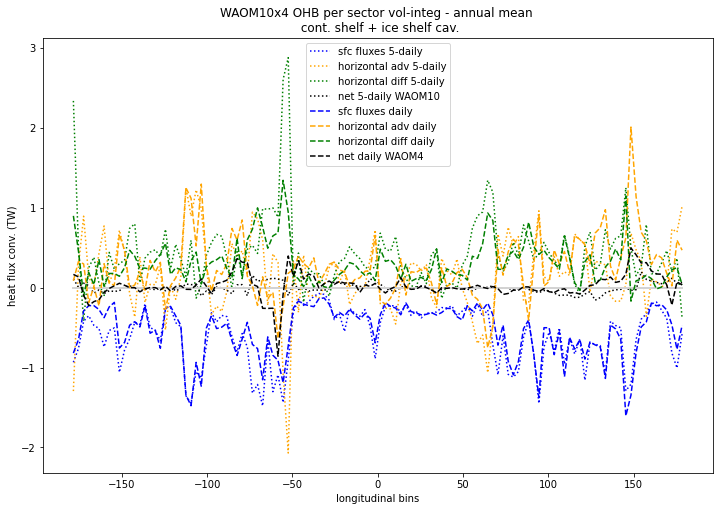

In [37]:
fig = plt.figure(figsize=(12,8))


plt.plot(lon_bins,(vdiff_5d).mean('ocean_time')*1e-12,':',color='b',
         label='sfc fluxes 5-daily')
plt.plot(lon_bins,(hadv_5d).mean('ocean_time')*1e-12,':',color='orange',
         label='horizontal adv 5-daily')
plt.plot(lon_bins,(hdiff_5d).mean('ocean_time')*1e-12,':',color='green',
         label='horizontal diff 5-daily')
plt.plot(lon_bins,(net_5d).mean('ocean_time')*1e-12,':',color='k',
         label='net 5-daily WAOM10')

plt.plot(lon_bins,(w4_net)*0,'-',color='lightgray')
plt.plot(lon_bins,(w4_vdiff).mean('ocean_time')*1e-12,'--',color='b',
         label='sfc fluxes daily')
plt.plot(lon_bins,(w4_hadv).mean('ocean_time')*1e-12,'--',color='orange',
         label='horizontal adv daily')
plt.plot(lon_bins,(w4_hdiff).mean('ocean_time')*1e-12,'--',color='green',
         label='horizontal diff daily')
plt.plot(lon_bins,(w4_net).mean('ocean_time')*1e-12,'--',color='k',
         label='net daily WAOM4')


plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW)')
plt.title('WAOM10x4 OHB per sector vol-integ - annual mean \n cont. shelf + ice shelf cav.')

Text(0.5, 1.0, 'WAOM4x4-NOTIDE OHB per sector vol-integ - annual mean \n cont. shelf + ice shelf cav.')

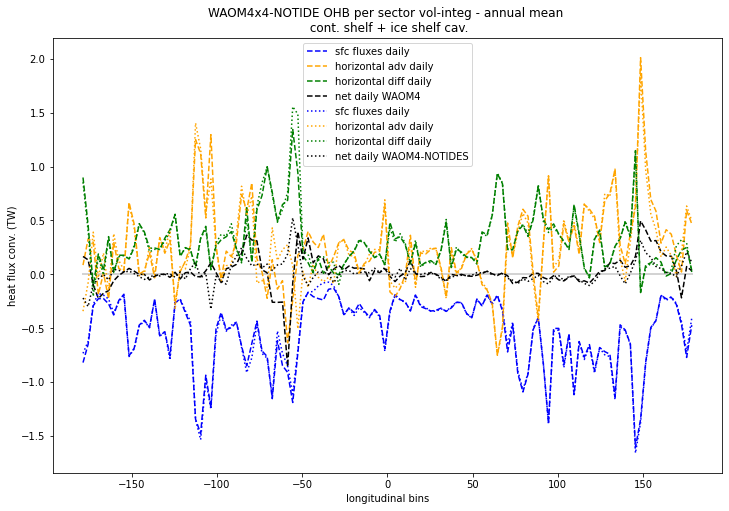

In [38]:
fig = plt.figure(figsize=(12,8))

plt.plot(lon_bins,(w4_net)*0,'-',color='lightgray')
plt.plot(lon_bins,(w4_vdiff).mean('ocean_time')*1e-12,'--',color='b',
         label='sfc fluxes daily')
plt.plot(lon_bins,(w4_hadv).mean('ocean_time')*1e-12,'--',color='orange',
         label='horizontal adv daily')
plt.plot(lon_bins,(w4_hdiff).mean('ocean_time')*1e-12,'--',color='green',
         label='horizontal diff daily')
plt.plot(lon_bins,(w4_net).mean('ocean_time')*1e-12,'--',color='k',
         label='net daily WAOM4')

plt.plot(lon_bins,(w4nt_vdiff).mean('ocean_time')*1e-12,':',color='b',
         label='sfc fluxes daily')
plt.plot(lon_bins,(w4nt_hadv).mean('ocean_time')*1e-12,':',color='orange',
         label='horizontal adv daily')
plt.plot(lon_bins,(w4nt_hdiff).mean('ocean_time')*1e-12,':',color='green',
         label='horizontal diff daily')
plt.plot(lon_bins,(w4nt_net).mean('ocean_time')*1e-12,':',color='k',
         label='net daily WAOM4-NOTIDES')

plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW)')
plt.title('WAOM4x4-NOTIDE OHB per sector vol-integ - annual mean \n cont. shelf + ice shelf cav.')

Text(0.5, 1.0, 'WAOM10 OHB per sector vol-integ - annual mean ')

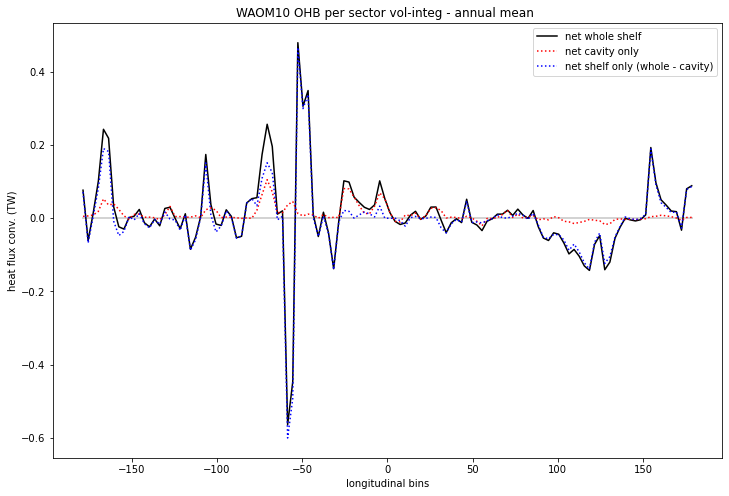

In [39]:
fig = plt.figure(figsize=(12,8))

plt.plot(lon_bins,(net)*0,'-',color='lightgray')
# plt.plot(lon_bins,(vdiff).mean('ocean_time')*1e-12,'--',color='b',
#          label='sfc fluxes daily')
# plt.plot(lon_bins,(hadv).mean('ocean_time')*1e-12,'--',color='orange',
#          label='horizontal adv daily')
# plt.plot(lon_bins,(hdiff).mean('ocean_time')*1e-12,'--',color='green',
#          label='horizontal diff daily')
plt.plot(lon_bins,(net).mean('ocean_time')*1e-12,'-',color='k',
         label='net whole shelf')

# plt.plot(lon_bins,(vdiff_is).mean('ocean_time')*1e-12,':',color='b',
#          label='sfc fluxes daily')
# plt.plot(lon_bins,(hadv_is).mean('ocean_time')*1e-12,':',color='orange',
#          label='horizontal adv daily')
# plt.plot(lon_bins,(hdiff_is).mean('ocean_time')*1e-12,':',color='green',
#          label='horizontal diff daily')
plt.plot(lon_bins,(net_is).mean('ocean_time')*1e-12,':',color='r',
         label='net cavity only')

plt.plot(lon_bins,(net-net_is).mean('ocean_time')*1e-12,':',color='b',
         label='net shelf only (whole - cavity)')

plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW)')
plt.title('WAOM10 OHB per sector vol-integ - annual mean ')

Text(0.5, 1.0, 'OHB per sector vol-integ - annual mean \n ice shelf cav.')

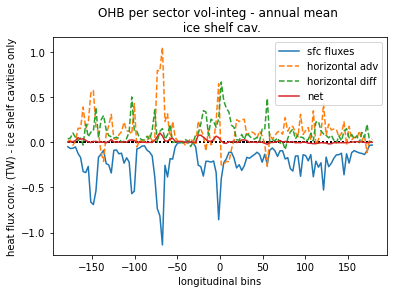

In [40]:
plt.plot(lon_bins,(net_is)*0,':k')
plt.plot(lon_bins,(vdiff_is).mean('ocean_time')*1e-12,label='sfc fluxes')
plt.plot(lon_bins,(hadv_is).mean('ocean_time')*1e-12,'--',label='horizontal adv')
plt.plot(lon_bins,(hdiff_is).mean('ocean_time')*1e-12,'--',label='horizontal diff')
plt.plot(lon_bins,(net_is).mean('ocean_time')*1e-12,label='net')
plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW) - ice shelf cavities only')
plt.title('OHB per sector vol-integ - annual mean \n ice shelf cav.')

Text(0.5, 1.0, 'Basal melting (mm/yr)')

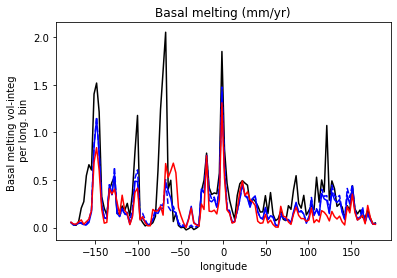

In [41]:
plt.plot(lon_bins,np.divide(np.nanmean(bmelt, axis=0),area_sum.values)*1000,'-k')
plt.plot(lon_bins,np.divide(np.nanmean(w4_bmelt, axis=0),area_sum.values)*1000,'-b')
plt.plot(lon_bins,np.divide(np.nanmean(w4nt_bmelt, axis=0),area_sum.values)*1000,'--b')
plt.plot(lon_bins,np.divide(np.nanmean(w2_bmelt, axis=0),area_sum.values)*1000,'-r')
plt.xlabel('longitude')
plt.ylabel('Basal melting vol-integ \n per long. bin')
plt.title('Basal melting (mm/yr)')

In [2]:
plt.plot(lon_bins,(net)*0,':k')
plt.plot(lon_bins,(vdiff).mean('ocean_time')*1e-12,label='sfc fluxes')
plt.plot(lon_bins,(hadv).mean('ocean_time')*1e-12,'--',label='horizontal adv')
plt.plot(lon_bins,(hdiff).mean('ocean_time')*1e-12,'--',label='horizontal diff')
plt.plot(lon_bins,(net).mean('ocean_time')*1e-12,label='net')
plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW) - cont. shelf only')
plt.title('OHB per sector vol-integ - annual mean \n whole shelf')
plt.ylim(-2,3)

NameError: name 'plt' is not defined

Text(0.5, 1.0, 'WAOM10 - OHB per sector vol-integ  and cumsummed \n annual mean')

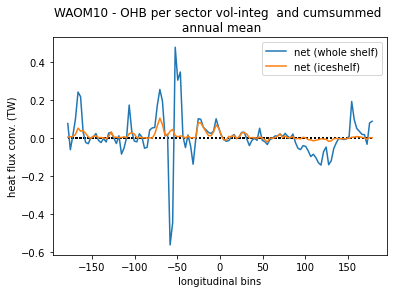

In [43]:
plt.plot(lon_bins,(net)*0,':k')
plt.plot(lon_bins,(net).mean('ocean_time')*1e-12,label='net (whole shelf)')
plt.plot(lon_bins,(net_is).mean('ocean_time')*1e-12,label='net (iceshelf)')
plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW)')
plt.title('WAOM10 - OHB per sector vol-integ  and cumsummed \n annual mean')

Text(0.5, 1.0, 'WAOM4 - OHB per sector vol-integ  and cumsummed \n annual mean')

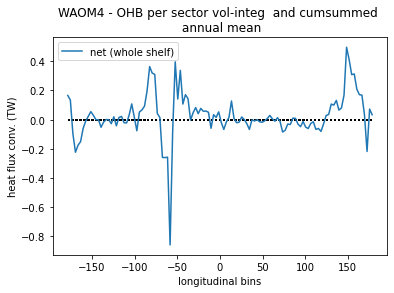

In [44]:
plt.plot(lon_bins,(net)*0,':k')
plt.plot(lon_bins,(w4_net).mean('ocean_time')*1e-12,label='net (whole shelf)')
# plt.plot(lon_bins,(w4_net_is).mean('ocean_time')*1e-12,label='net (iceshelf)')
plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW)')
plt.title('WAOM4 - OHB per sector vol-integ  and cumsummed \n annual mean')

#### seasonal plots for each experiment:

In [45]:
## cumsum plot with 4 panels:
# 1. cumsum net (cont shelf), annual + seasons
# 2. cumsum RHS (cont shelf), annual + seasons
# 3. cumsum net (ice shelf), annual + seasons
# 4. cumsum RHS (ice shelf), annual + seasons

In [46]:
# plt.plot(range(0,92),',')
print(len(range(0,92)),
      len(range(92,183)),
      len(range(183,274)),
      len(range(274,365)))


92 91 91 91


In [47]:
# - indexes (daily):

print(np.arange(0,92),np.arange(92,183),np.arange(183,274),np.arange(274,365))
print(np.arange(0,92).shape,np.arange(92,183).shape,np.arange(183,274).shape,np.arange(274,365).shape)

s1i = 0
s1e = 92
s2i = 92
s2e = 183
s3i = 183
s3e = 274
s4i = 274
s4e = 365


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91] [ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182] [183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268

In [48]:
# - indexes (5-daily):

print(np.arange(0,19),np.arange(19,37),np.arange(37,55),np.arange(55,73))
print(np.arange(0,19).shape,np.arange(19,37).shape,np.arange(37,55).shape,np.arange(55,73).shape)

s1i_5d = 0
s1e_5d = 19
s2i_5d = 19
s2e_5d = 37
s3i_5d = 37
s3e_5d = 55
s4i_5d = 55
s4e_5d = 73

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36] [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54] [55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
(19,) (18,) (18,) (18,)


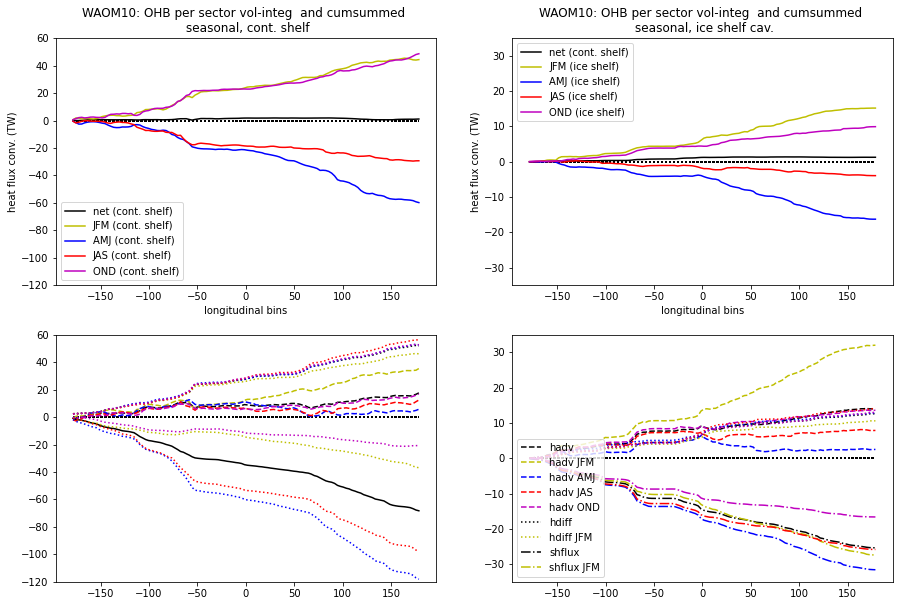

In [49]:
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(221)# projection=proj)
ax1.plot(lon_bins,(net)*0,':k')
ax1.plot(lon_bins,(net).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (cont. shelf)')
ax1.legend()
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('heat flux conv. (TW)')
ax1.set_title('WAOM10: OHB per sector vol-integ  and cumsummed \n seasonal, cont. shelf')
ax1.set_ylim(-120,60)

ax2 = fig.add_subplot(223)# projection=proj)
ax2.plot(lon_bins,(net)*0,':k')
ax2.plot(lon_bins,(hadv).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax2.plot(lon_bins,(hdiff).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax2.plot(lon_bins,(hdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax2.plot(lon_bins,(hdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax2.plot(lon_bins,(hdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax2.plot(lon_bins,(hdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax2.plot(lon_bins,(vdiff).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax2.plot(lon_bins,(vdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax2.plot(lon_bins,(vdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax2.plot(lon_bins,(vdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax2.plot(lon_bins,(vdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
# ax2.legend()
# ax2.set_title('OHB per sector vol-integ  and cumsummed \n annual + seasonal')
ax2.set_ylim(-120,60)

ax3 = fig.add_subplot(222)# projection=proj)
ax3.plot(lon_bins,(net)*0,':k')
ax3.plot(lon_bins,(net_is).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (ice shelf)')
ax3.legend()
ax3.set_xlabel('longitudinal bins')
ax3.set_ylabel('heat flux conv. (TW)')
ax3.set_title('WAOM10: OHB per sector vol-integ  and cumsummed \n seasonal, ice shelf cav.')
ax3.set_ylim(-35,35)

ax4 = fig.add_subplot(224)# projection=proj)
ax4.plot(lon_bins,(net)*0,':k')
ax4.plot(lon_bins,(hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax4.plot(lon_bins,(hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b')#,label='hdiff AMJ')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r')#,label='hdiff JAS')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m')#,label='hdiff OND')
ax4.plot(lon_bins,(vdiff_is).mean('ocean_time').cumsum()*1e-12,'-.k',label='shflux')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'-.y',label='shflux JFM')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'-.b')#,label='shflux AMJ')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'-.r')#,label='shflux JAS')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'-.m')#,label='shflux OND')
ax4.legend(loc='lower left')
ax4.set_ylim(-35,35)

name_fig='waom10_lonbin_regional_OHBcumsum_seasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')

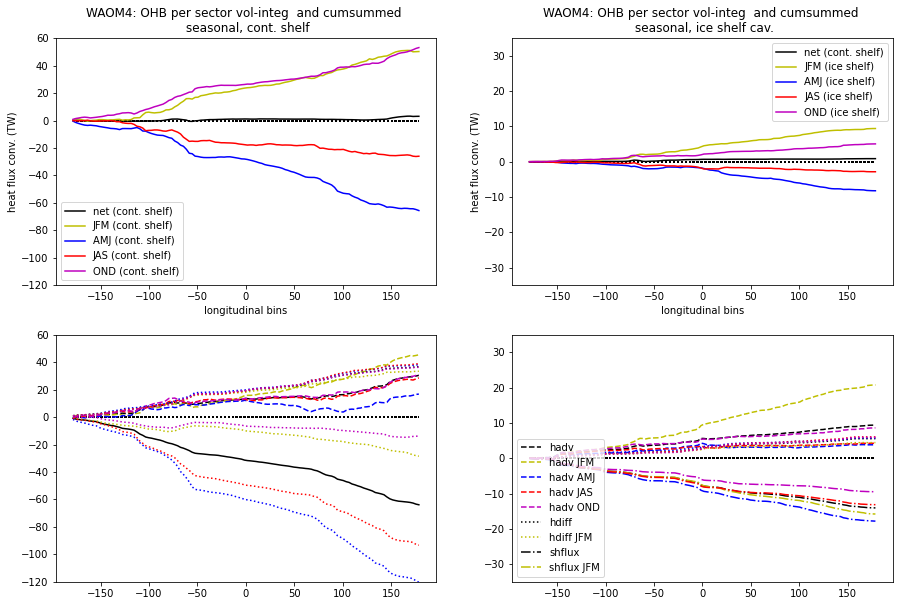

In [50]:
fig = plt.figure(figsize=(15,10))

# Original WAOM4
ax1 = fig.add_subplot(221)# projection=proj)
ax1.plot(lon_bins,(w4_net)*0,':k')
ax1.plot(lon_bins,(w4_net).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(w4_net).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(w4_net).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(w4_net).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(w4_net).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (cont. shelf)')
ax1.legend()
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('heat flux conv. (TW)')
ax1.set_title('WAOM4: OHB per sector vol-integ  and cumsummed \n seasonal, cont. shelf')
ax1.set_ylim(-120,60)

ax2 = fig.add_subplot(223)# projection=proj)
ax2.plot(lon_bins,(w4_net)*0,':k')
ax2.plot(lon_bins,(w4_hadv).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(w4_hadv).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(w4_hadv).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(w4_hadv).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(w4_hadv).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax2.plot(lon_bins,(w4_hdiff).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax2.plot(lon_bins,(w4_hdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax2.plot(lon_bins,(w4_hdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax2.plot(lon_bins,(w4_hdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax2.plot(lon_bins,(w4_hdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax2.plot(lon_bins,(w4_vdiff).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax2.plot(lon_bins,(w4_vdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax2.plot(lon_bins,(w4_vdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax2.plot(lon_bins,(w4_vdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax2.plot(lon_bins,(w4_vdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
# ax2.legend()
# ax2.set_title('OHB per sector vol-integ  and cumsummed \n annual + seasonal')
ax2.set_ylim(-120,60)

ax3 = fig.add_subplot(222)# projection=proj)
ax3.plot(lon_bins,(w4_net)*0,':k')
ax3.plot(lon_bins,(w4_net_is).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax3.plot(lon_bins,(w4_net_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (ice shelf)')
ax3.plot(lon_bins,(w4_net_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (ice shelf)')
ax3.plot(lon_bins,(w4_net_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (ice shelf)')
ax3.plot(lon_bins,(w4_net_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (ice shelf)')
ax3.legend()
ax3.set_xlabel('longitudinal bins')
ax3.set_ylabel('heat flux conv. (TW)')
ax3.set_title('WAOM4: OHB per sector vol-integ  and cumsummed \n seasonal, ice shelf cav.')
ax3.set_ylim(-35,35)

ax4 = fig.add_subplot(224)# projection=proj)
ax4.plot(lon_bins,(w4_net)*0,':k')
ax4.plot(lon_bins,(w4_hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(w4_hadv_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(w4_hadv_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(w4_hadv_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(w4_hadv_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax4.plot(lon_bins,(w4_hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax4.plot(lon_bins,(w4_hdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax4.plot(lon_bins,(w4_hdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b')#,label='hdiff AMJ')
ax4.plot(lon_bins,(w4_hdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r')#,label='hdiff JAS')
ax4.plot(lon_bins,(w4_hdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m')#,label='hdiff OND')
ax4.plot(lon_bins,(w4_vdiff_is).mean('ocean_time').cumsum()*1e-12,'-.k',label='shflux')
ax4.plot(lon_bins,(w4_vdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'-.y',label='shflux JFM')
ax4.plot(lon_bins,(w4_vdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'-.b')#,label='shflux AMJ')
ax4.plot(lon_bins,(w4_vdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'-.r')#,label='shflux JAS')
ax4.plot(lon_bins,(w4_vdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'-.m')#,label='shflux OND')
ax4.legend(loc='lower left')
ax4.set_ylim(-35,35)

name_fig='waom4_lonbin_regional_OHBcumsum_seasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')

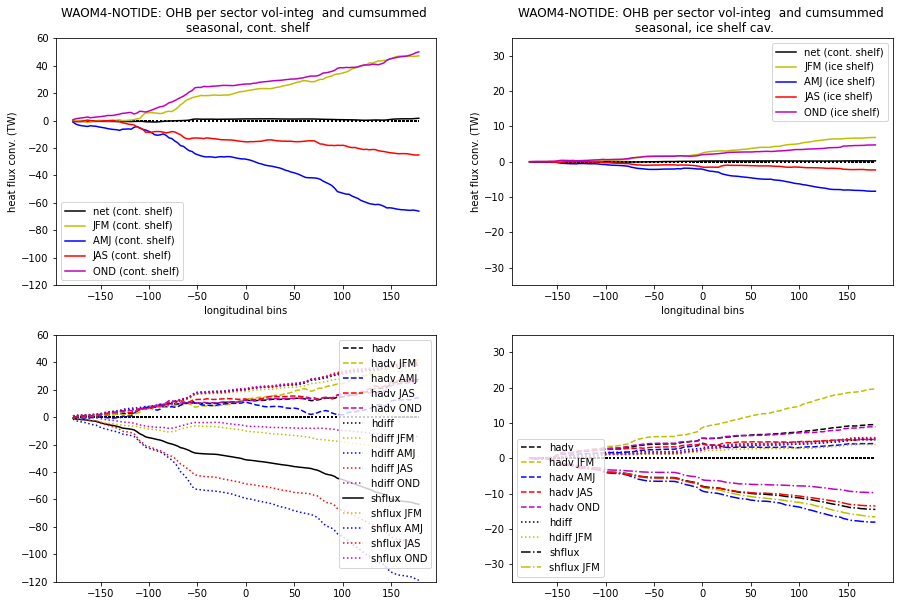

In [51]:
fig = plt.figure(figsize=(15,10))

# WAOM4-NOTIDE
ax1 = fig.add_subplot(221)# projection=proj)
ax1.plot(lon_bins,(w4nt_net)*0,':k')
ax1.plot(lon_bins,(w4nt_net).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(w4nt_net).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(w4nt_net).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(w4nt_net).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(w4nt_net).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (cont. shelf)')
ax1.legend()
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('heat flux conv. (TW)')
ax1.set_title('WAOM4-NOTIDE: OHB per sector vol-integ  and cumsummed \n seasonal, cont. shelf')
ax1.set_ylim(-120,60)

ax2 = fig.add_subplot(223)# projection=proj)
ax2.plot(lon_bins,(w4nt_net)*0,':k')
ax2.plot(lon_bins,(w4nt_hadv).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(w4nt_hadv).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(w4nt_hadv).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(w4nt_hadv).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(w4nt_hadv).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax2.plot(lon_bins,(w4nt_hdiff).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax2.plot(lon_bins,(w4nt_hdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax2.plot(lon_bins,(w4nt_hdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax2.plot(lon_bins,(w4nt_hdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax2.plot(lon_bins,(w4nt_hdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax2.plot(lon_bins,(w4nt_vdiff).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax2.plot(lon_bins,(w4nt_vdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax2.plot(lon_bins,(w4nt_vdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax2.plot(lon_bins,(w4nt_vdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax2.plot(lon_bins,(w4nt_vdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
ax2.legend()
# ax2.set_title('OHB per sector vol-integ  and cumsummed \n annual + seasonal')
ax2.set_ylim(-120,60)

ax3 = fig.add_subplot(222)# projection=proj)
ax3.plot(lon_bins,(w4nt_net)*0,':k')
ax3.plot(lon_bins,(w4nt_net_is).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax3.plot(lon_bins,(w4nt_net_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (ice shelf)')
ax3.plot(lon_bins,(w4nt_net_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (ice shelf)')
ax3.plot(lon_bins,(w4nt_net_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (ice shelf)')
ax3.plot(lon_bins,(w4nt_net_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (ice shelf)')
ax3.legend()
ax3.set_xlabel('longitudinal bins')
ax3.set_ylabel('heat flux conv. (TW)')
ax3.set_title('WAOM4-NOTIDE: OHB per sector vol-integ  and cumsummed \n seasonal, ice shelf cav.')
ax3.set_ylim(-35,35)

ax4 = fig.add_subplot(224)# projection=proj)
ax4.plot(lon_bins,(w4nt_net)*0,':k')
ax4.plot(lon_bins,(w4nt_hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(w4nt_hadv_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(w4nt_hadv_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(w4nt_hadv_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(w4nt_hadv_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax4.plot(lon_bins,(w4nt_hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax4.plot(lon_bins,(w4nt_hdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax4.plot(lon_bins,(w4nt_hdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b')#,label='hdiff AMJ')
ax4.plot(lon_bins,(w4nt_hdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r')#,label='hdiff JAS')
ax4.plot(lon_bins,(w4nt_hdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m')#,label='hdiff OND')
ax4.plot(lon_bins,(w4nt_vdiff_is).mean('ocean_time').cumsum()*1e-12,'-.k',label='shflux')
ax4.plot(lon_bins,(w4nt_vdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'-.y',label='shflux JFM')
ax4.plot(lon_bins,(w4nt_vdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'-.b')#,label='shflux AMJ')
ax4.plot(lon_bins,(w4nt_vdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'-.r')#,label='shflux JAS')
ax4.plot(lon_bins,(w4nt_vdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'-.m')#,label='shflux OND')
ax4.legend(loc='lower left')
ax4.set_ylim(-35,35)
name_fig='waom4-notides_lonbin_regional_OHBcumsum_seasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')

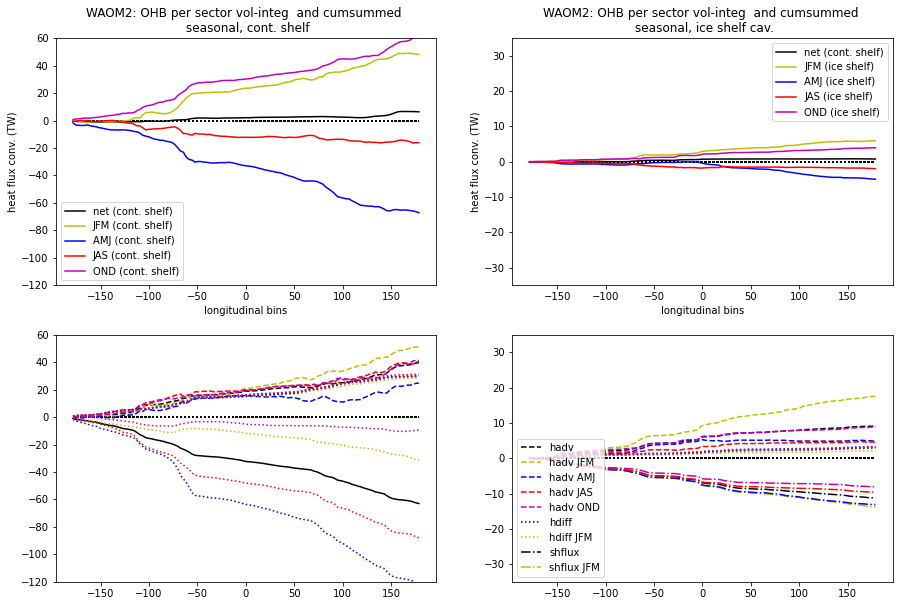

In [52]:
fig = plt.figure(figsize=(15,10))

# Original WAOM2
ax1 = fig.add_subplot(221)# projection=proj)
ax1.plot(lon_bins,(w2_net)*0,':k')
ax1.plot(lon_bins,(w2_net).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(w2_net).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(w2_net).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(w2_net).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(w2_net).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (cont. shelf)')
ax1.legend()
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('heat flux conv. (TW)')
ax1.set_title('WAOM2: OHB per sector vol-integ  and cumsummed \n seasonal, cont. shelf')
ax1.set_ylim(-120,60)

ax2 = fig.add_subplot(223)# projection=proj)
ax2.plot(lon_bins,(w2_net)*0,':k')
ax2.plot(lon_bins,(w2_hadv).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(w2_hadv).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(w2_hadv).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(w2_hadv).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(w2_hadv).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax2.plot(lon_bins,(w2_hdiff).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax2.plot(lon_bins,(w2_hdiff).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax2.plot(lon_bins,(w2_hdiff).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax2.plot(lon_bins,(w2_hdiff).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax2.plot(lon_bins,(w2_hdiff).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax2.plot(lon_bins,(w2_vdiff).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax2.plot(lon_bins,(w2_vdiff).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax2.plot(lon_bins,(w2_vdiff).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax2.plot(lon_bins,(w2_vdiff).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax2.plot(lon_bins,(w2_vdiff).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
# ax2.legend()
# ax2.set_title('OHB per sector vol-integ  and cumsummed \n annual + seasonal')
ax2.set_ylim(-120,60)

ax3 = fig.add_subplot(222)# projection=proj)
ax3.plot(lon_bins,(w2_net)*0,':k')
ax3.plot(lon_bins,(w2_net_is).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax3.plot(lon_bins,(w2_net_is).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (ice shelf)')
ax3.plot(lon_bins,(w2_net_is).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (ice shelf)')
ax3.plot(lon_bins,(w2_net_is).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (ice shelf)')
ax3.plot(lon_bins,(w2_net_is).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (ice shelf)')
ax3.legend()
ax3.set_xlabel('longitudinal bins')
ax3.set_ylabel('heat flux conv. (TW)')
ax3.set_title('WAOM2: OHB per sector vol-integ  and cumsummed \n seasonal, ice shelf cav.')
ax3.set_ylim(-35,35)

ax4 = fig.add_subplot(224)# projection=proj)
ax4.plot(lon_bins,(w2_net)*0,':k')
ax4.plot(lon_bins,(w2_hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(w2_hadv_is).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(w2_hadv_is).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(w2_hadv_is).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(w2_hadv_is).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax4.plot(lon_bins,(w2_hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax4.plot(lon_bins,(w2_hdiff_is).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax4.plot(lon_bins,(w2_hdiff_is).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b')#,label='hdiff AMJ')
ax4.plot(lon_bins,(w2_hdiff_is).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r')#,label='hdiff JAS')
ax4.plot(lon_bins,(w2_hdiff_is).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m')#,label='hdiff OND')
ax4.plot(lon_bins,(w2_vdiff_is).mean('ocean_time').cumsum()*1e-12,'-.k',label='shflux')
ax4.plot(lon_bins,(w2_vdiff_is).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'-.y',label='shflux JFM')
ax4.plot(lon_bins,(w2_vdiff_is).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'-.b')#,label='shflux AMJ')
ax4.plot(lon_bins,(w2_vdiff_is).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'-.r')#,label='shflux JAS')
ax4.plot(lon_bins,(w2_vdiff_is).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'-.m')#,label='shflux OND')
ax4.legend(loc='lower left')
ax4.set_ylim(-35,35)

name_fig='waom2_lonbin_regional_OHBcumsum_seasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


The plots above and their comparison show us that across model horiz resolution, the warming from horiz diffusion decreases with higher resolution, while the warming from horiz advection increases with higher resolution. This is specially evident in East Antarctica. Also west ant. has clear warming signal (seem as positve sloped curves in the cumsum lines in figures above).

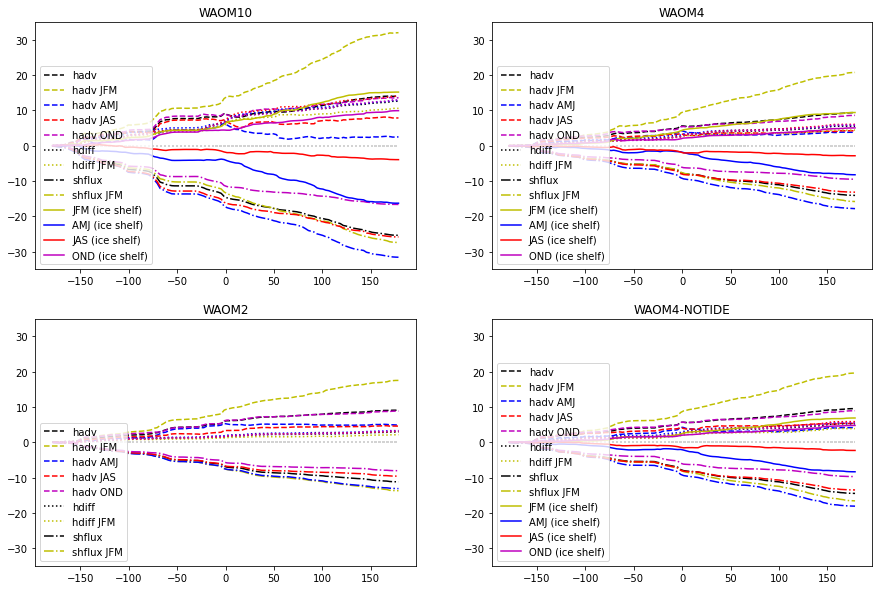

In [53]:
# final seasonal plot: all processes+net cumsum into a sigle subplot (4 subplots, 1each expt)

fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax4 = fig.add_subplot(221)# projection=proj)
ax4.plot(lon_bins,(net)*0,':',color='lightgray')
# hadv
ax4.plot(lon_bins,(hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
# hdiff
ax4.plot(lon_bins,(hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b')#,label='hdiff AMJ')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r')#,label='hdiff JAS')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m')#,label='hdiff OND')
# sfc flx
ax4.plot(lon_bins,(vdiff_is).mean('ocean_time').cumsum()*1e-12,'-.k',label='shflux')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'-.y',label='shflux JFM')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'-.b')#,label='shflux AMJ')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'-.r')#,label='shflux JAS')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'-.m')#,label='shflux OND')
#net
ax4.plot(lon_bins,(net_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'-y',label='JFM (ice shelf)')
ax4.plot(lon_bins,(net_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'-b',label='AMJ (ice shelf)')
ax4.plot(lon_bins,(net_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'-r',label='JAS (ice shelf)')
ax4.plot(lon_bins,(net_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'-m',label='OND (ice shelf)')
ax4.legend(loc='lower left')
ax4.set_ylim(-35,35)
ax4.set_title('WAOM10')

# Original WAOM4
ax4 = fig.add_subplot(222)# projection=proj)
ax4.plot(lon_bins,(net)*0,':',color='lightgray')
# hadv
ax4.plot(lon_bins,(w4_hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(w4_hadv_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(w4_hadv_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(w4_hadv_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(w4_hadv_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
# hdiff
ax4.plot(lon_bins,(w4_hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax4.plot(lon_bins,(w4_hdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax4.plot(lon_bins,(w4_hdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b')#,label='hdiff AMJ')
ax4.plot(lon_bins,(w4_hdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r')#,label='hdiff JAS')
ax4.plot(lon_bins,(w4_hdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m')#,label='hdiff OND')
# sfc flx
ax4.plot(lon_bins,(w4_vdiff_is).mean('ocean_time').cumsum()*1e-12,'-.k',label='shflux')
ax4.plot(lon_bins,(w4_vdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'-.y',label='shflux JFM')
ax4.plot(lon_bins,(w4_vdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'-.b')#,label='shflux AMJ')
ax4.plot(lon_bins,(w4_vdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'-.r')#,label='shflux JAS')
ax4.plot(lon_bins,(w4_vdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'-.m')#,label='shflux OND')
#net
ax4.plot(lon_bins,(w4_net_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'-y',label='JFM (ice shelf)')
ax4.plot(lon_bins,(w4_net_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'-b',label='AMJ (ice shelf)')
ax4.plot(lon_bins,(w4_net_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'-r',label='JAS (ice shelf)')
ax4.plot(lon_bins,(w4_net_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'-m',label='OND (ice shelf)')
ax4.legend(loc='lower left')
ax4.set_ylim(-35,35)
ax4.set_title('WAOM4')

# Original WAOM2
ax4 = fig.add_subplot(223)# projection=proj)
ax4.plot(lon_bins,(net)*0,':',color='lightgray')
# hadv
ax4.plot(lon_bins,(w2_hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(w2_hadv_is).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(w2_hadv_is).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(w2_hadv_is).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(w2_hadv_is).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
# hdiff
ax4.plot(lon_bins,(w2_hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax4.plot(lon_bins,(w2_hdiff_is).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax4.plot(lon_bins,(w2_hdiff_is).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b')#,label='hdiff AMJ')
ax4.plot(lon_bins,(w2_hdiff_is).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r')#,label='hdiff JAS')
ax4.plot(lon_bins,(w2_hdiff_is).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m')#,label='hdiff OND')
# sfc flx
ax4.plot(lon_bins,(w2_vdiff_is).mean('ocean_time').cumsum()*1e-12,'-.k',label='shflux')
ax4.plot(lon_bins,(w2_vdiff_is).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'-.y',label='shflux JFM')
ax4.plot(lon_bins,(w2_vdiff_is).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'-.b')#,label='shflux AMJ')
ax4.plot(lon_bins,(w2_vdiff_is).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'-.r')#,label='shflux JAS')
ax4.plot(lon_bins,(w2_vdiff_is).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'-.m')#,label='shflux OND')
#net
# ax4.plot(lon_bins,(w2_net_is).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'-y',label='JFM (ice shelf)')
# ax4.plot(lon_bins,(w2_net_is).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'-b',label='AMJ (ice shelf)')
# ax4.plot(lon_bins,(w2_net_is).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'-r',label='JAS (ice shelf)')
# ax4.plot(lon_bins,(w2_net_is).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'-m',label='OND (ice shelf)')
ax4.legend(loc='lower left')
ax4.set_ylim(-35,35)
ax4.set_title('WAOM2')

# Original WAOM4
ax4 = fig.add_subplot(224)# projection=proj)
ax4.plot(lon_bins,(net)*0,':',color='lightgray')
# hadv
ax4.plot(lon_bins,(w4nt_hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(w4nt_hadv_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(w4nt_hadv_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(w4nt_hadv_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(w4nt_hadv_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
# hdiff
ax4.plot(lon_bins,(w4nt_hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax4.plot(lon_bins,(w4nt_hdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax4.plot(lon_bins,(w4nt_hdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b')#,label='hdiff AMJ')
ax4.plot(lon_bins,(w4nt_hdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r')#,label='hdiff JAS')
ax4.plot(lon_bins,(w4nt_hdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m')#,label='hdiff OND')
# sfc flx
ax4.plot(lon_bins,(w4nt_vdiff_is).mean('ocean_time').cumsum()*1e-12,'-.k',label='shflux')
ax4.plot(lon_bins,(w4nt_vdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'-.y',label='shflux JFM')
ax4.plot(lon_bins,(w4nt_vdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'-.b')#,label='shflux AMJ')
ax4.plot(lon_bins,(w4nt_vdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'-.r')#,label='shflux JAS')
ax4.plot(lon_bins,(w4nt_vdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'-.m')#,label='shflux OND')
#net
ax4.plot(lon_bins,(w4nt_net_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'-y',label='JFM (ice shelf)')
ax4.plot(lon_bins,(w4nt_net_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'-b',label='AMJ (ice shelf)')
ax4.plot(lon_bins,(w4nt_net_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'-r',label='JAS (ice shelf)')
ax4.plot(lon_bins,(w4nt_net_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'-m',label='OND (ice shelf)')
ax4.legend(loc='lower left')
ax4.set_ylim(-35,35)
ax4.set_title('WAOM4-NOTIDE')

name_fig='waom10x4x4NTx2_lonbin_regional_OHBcumsum_seasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight', facecolor='white')

#### plot to check matching with whole Antarctica OHB figures:

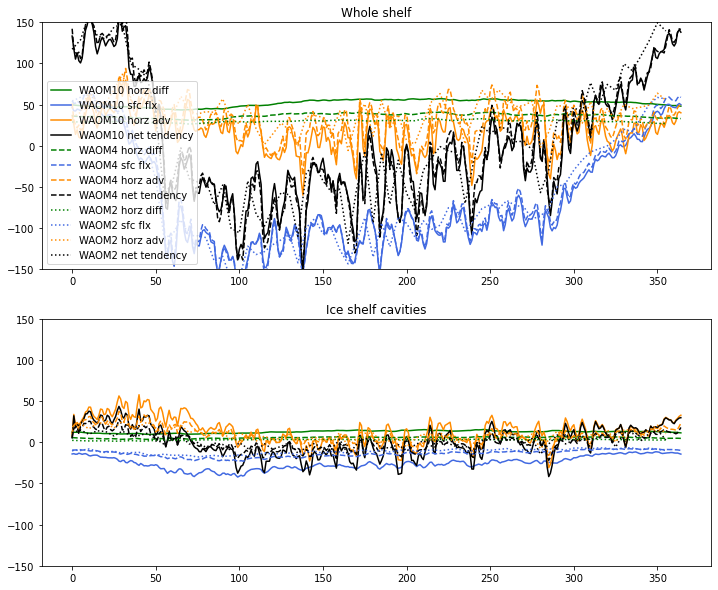

In [54]:
# now get the last values (=circum-Antarctic integrated value) and plot over time to match with OHB figures:

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,1,1, frameon=True)

ax1.plot(np.arange(0,365,1),hdiff.sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(np.arange(0,365,1),vdiff.sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(np.arange(0,365,1),hadv.sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax1.plot(np.arange(0,365,1),net.sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax1.plot(np.arange(0,365,1),w4_hdiff.sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(np.arange(0,365,1),w4_vdiff.sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(np.arange(0,365,1),w4_hadv.sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax1.plot(np.arange(0,365,1),w4_net.sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax1.plot(np.arange(0,360,5),w2_hdiff.sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(np.arange(0,360,5),w2_vdiff.sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(np.arange(0,360,5),w2_hadv.sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax1.plot(np.arange(0,360,5),w2_net.sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax1.legend(loc='best')
ax1.set_title('Whole shelf')
ax1.set_ylim(-150,150)

ax2 = fig.add_subplot(2,1,2, frameon=True)

ax2.plot(np.arange(0,365,1),hdiff_is.sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax2.plot(np.arange(0,365,1),vdiff_is.sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax2.plot(np.arange(0,365,1),hadv_is.sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax2.plot(np.arange(0,365,1),net_is.sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax2.plot(np.arange(0,365,1),w4_hdiff_is.sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax2.plot(np.arange(0,365,1),w4_vdiff_is.sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax2.plot(np.arange(0,365,1),w4_hadv_is.sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax2.plot(np.arange(0,365,1),w4_net_is.sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax2.plot(np.arange(0,360,5),w2_hdiff_is.sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax2.plot(np.arange(0,360,5),w2_vdiff_is.sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax2.plot(np.arange(0,360,5),w2_hadv_is.sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax2.plot(np.arange(0,360,5),w2_net_is.sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax2.set_title('Ice shelf cavities')
ax2.set_ylim(-150,150)


name_fig='waom10x4x2_lonbin_circumpolar-integ_OHB_daily.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight', facecolor='white')

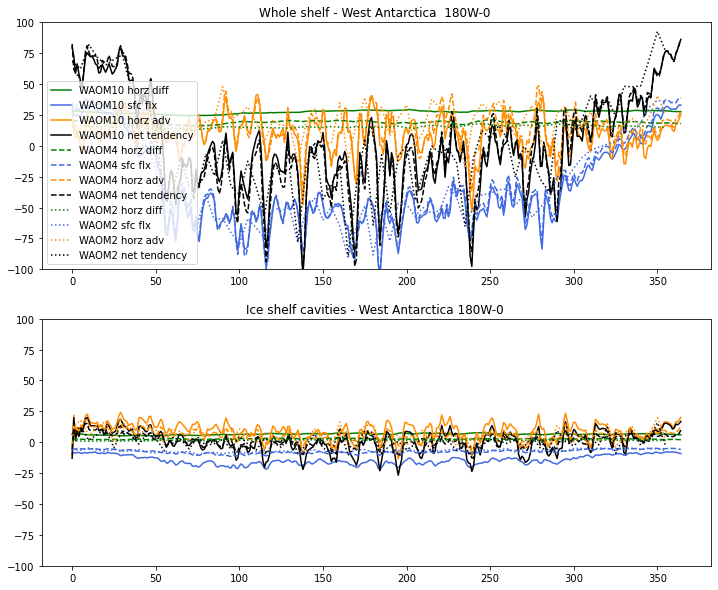

In [55]:
## same as above but splitting in West and East Antarctica:

# now get the last values (=circum-Antarctic integrated value) and plot over time to match with OHB figures:

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,1,1, frameon=True)

ax1.plot(np.arange(0,365,1),hdiff.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(np.arange(0,365,1),vdiff.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(np.arange(0,365,1),hadv.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax1.plot(np.arange(0,365,1),net.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax1.plot(np.arange(0,365,1),w4_hdiff.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(np.arange(0,365,1),w4_vdiff.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(np.arange(0,365,1),w4_hadv.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax1.plot(np.arange(0,365,1),w4_net.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax1.plot(np.arange(0,360,5),w2_hdiff.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(np.arange(0,360,5),w2_vdiff.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(np.arange(0,360,5),w2_hadv.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax1.plot(np.arange(0,360,5),w2_net.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax1.legend(loc='best')
ax1.set_title('Whole shelf - West Antarctica  180W-0 ')
ax1.set_ylim(-100,100)

ax2 = fig.add_subplot(2,1,2, frameon=True)

ax2.plot(np.arange(0,365,1),hdiff_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax2.plot(np.arange(0,365,1),vdiff_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax2.plot(np.arange(0,365,1),hadv_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax2.plot(np.arange(0,365,1),net_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax2.plot(np.arange(0,365,1),w4_hdiff_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax2.plot(np.arange(0,365,1),w4_vdiff_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax2.plot(np.arange(0,365,1),w4_hadv_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax2.plot(np.arange(0,365,1),w4_net_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax2.plot(np.arange(0,360,5),w2_hdiff_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax2.plot(np.arange(0,360,5),w2_vdiff_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax2.plot(np.arange(0,360,5),w2_hadv_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax2.plot(np.arange(0,360,5),w2_net_is.isel(lon_bins=slice(0,60)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax2.set_title('Ice shelf cavities - West Antarctica 180W-0 ')
ax2.set_ylim(-100,100)


name_fig='waom10x4x2_lonbin_180W-0-integ_OHB_daily.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight', facecolor='white')

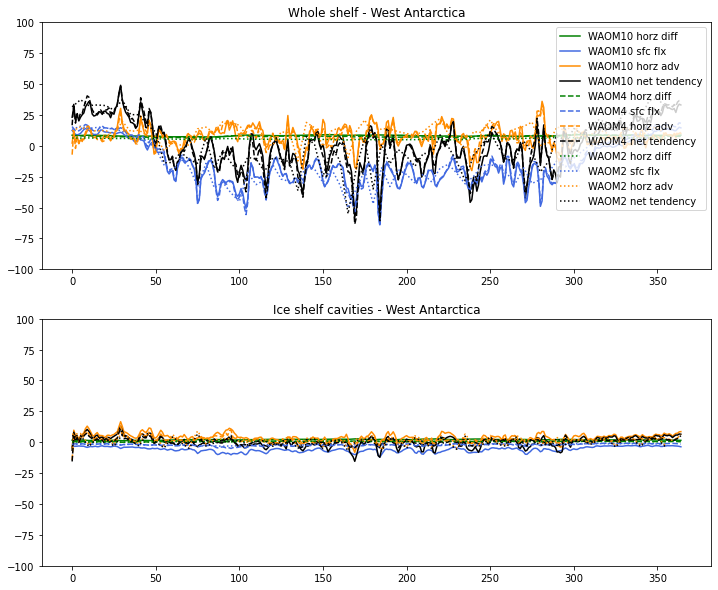

In [56]:
## same as above but splitting in West and East Antarctica:

# now get the last values (=circum-Antarctic integrated value) and plot over time to match with OHB figures:

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,1,1, frameon=True)

ax1.plot(np.arange(0,365,1),hdiff.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(np.arange(0,365,1),vdiff.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(np.arange(0,365,1),hadv.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax1.plot(np.arange(0,365,1),net.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax1.plot(np.arange(0,365,1),w4_hdiff.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(np.arange(0,365,1),w4_vdiff.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(np.arange(0,365,1),w4_hadv.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax1.plot(np.arange(0,365,1),w4_net.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax1.plot(np.arange(0,360,5),w2_hdiff.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(np.arange(0,360,5),w2_vdiff.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(np.arange(0,360,5),w2_hadv.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax1.plot(np.arange(0,360,5),w2_net.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax1.legend(loc='best')
ax1.set_title('Whole shelf - West Antarctica')
ax1.set_ylim(-100,100)

ax2 = fig.add_subplot(2,1,2, frameon=True)

ax2.plot(np.arange(0,365,1),hdiff_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax2.plot(np.arange(0,365,1),vdiff_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax2.plot(np.arange(0,365,1),hadv_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax2.plot(np.arange(0,365,1),net_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax2.plot(np.arange(0,365,1),w4_hdiff_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax2.plot(np.arange(0,365,1),w4_vdiff_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax2.plot(np.arange(0,365,1),w4_hadv_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax2.plot(np.arange(0,365,1),w4_net_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax2.plot(np.arange(0,360,5),w2_hdiff_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax2.plot(np.arange(0,360,5),w2_vdiff_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax2.plot(np.arange(0,360,5),w2_hadv_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax2.plot(np.arange(0,360,5),w2_net_is.isel(lon_bins=slice(18,38)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax2.set_title('Ice shelf cavities - West Antarctica')
ax2.set_ylim(-100,100)


name_fig='waom10x4x2_lonbin_WestAnt_OHB_daily.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight', facecolor='white')

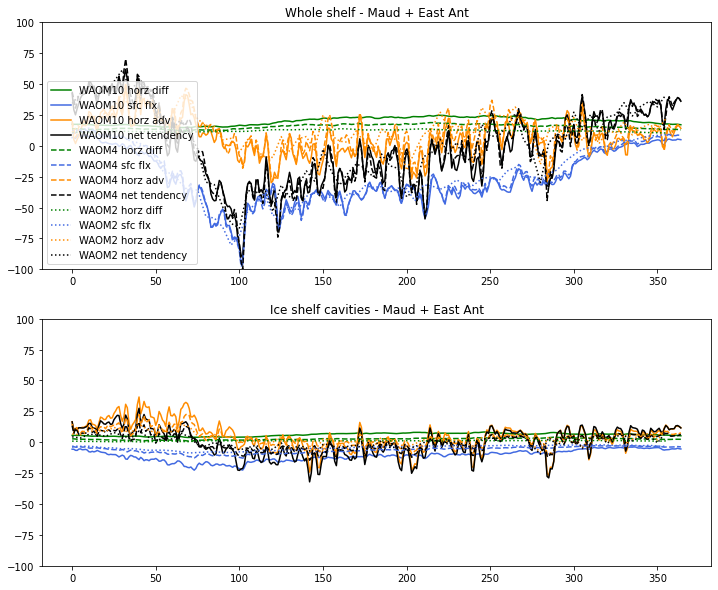

In [57]:
## same as above but splitting in West and East Antarctica:

# now get the last values (=circum-Antarctic integrated value) and plot over time to match with OHB figures:

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,1,1, frameon=True)

ax1.plot(np.arange(0,365,1),hdiff.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(np.arange(0,365,1),vdiff.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(np.arange(0,365,1),hadv.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax1.plot(np.arange(0,365,1),net.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax1.plot(np.arange(0,365,1),w4_hdiff.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(np.arange(0,365,1),w4_vdiff.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(np.arange(0,365,1),w4_hadv.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax1.plot(np.arange(0,365,1),w4_net.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax1.plot(np.arange(0,360,5),w2_hdiff.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(np.arange(0,360,5),w2_vdiff.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(np.arange(0,360,5),w2_hadv.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax1.plot(np.arange(0,360,5),w2_net.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax1.legend(loc='best')
ax1.set_title('Whole shelf - Maud + East Ant')
ax1.set_ylim(-100,100)

ax2 = fig.add_subplot(2,1,2, frameon=True)

ax2.plot(np.arange(0,365,1),hdiff_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax2.plot(np.arange(0,365,1),vdiff_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax2.plot(np.arange(0,365,1),hadv_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax2.plot(np.arange(0,365,1),net_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax2.plot(np.arange(0,365,1),w4_hdiff_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax2.plot(np.arange(0,365,1),w4_vdiff_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax2.plot(np.arange(0,365,1),w4_hadv_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax2.plot(np.arange(0,365,1),w4_net_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax2.plot(np.arange(0,360,5),w2_hdiff_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax2.plot(np.arange(0,360,5),w2_vdiff_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax2.plot(np.arange(0,360,5),w2_hadv_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax2.plot(np.arange(0,360,5),w2_net_is.isel(lon_bins=slice(55,105)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax2.set_title('Ice shelf cavities - Maud + East Ant')
ax2.set_ylim(-100,100)


name_fig='waom10x4x2_lonbin_Maud-EastAnt_OHB_daily.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight', facecolor='white')

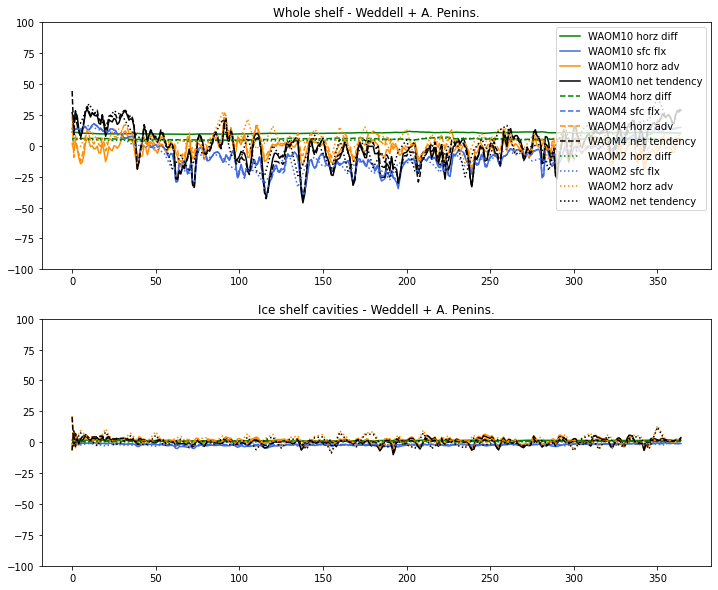

In [58]:
## Weddell + P.A.:
## same as above but splitting in West and East Antarctica:

# now get the last values (=circum-Antarctic integrated value) and plot over time to match with OHB figures:

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,1,1, frameon=True)

ax1.plot(np.arange(0,365,1),hdiff.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(np.arange(0,365,1),vdiff.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(np.arange(0,365,1),hadv.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax1.plot(np.arange(0,365,1),net.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax1.plot(np.arange(0,365,1),w4_hdiff.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(np.arange(0,365,1),w4_vdiff.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(np.arange(0,365,1),w4_hadv.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax1.plot(np.arange(0,365,1),w4_net.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax1.plot(np.arange(0,360,5),w2_hdiff.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(np.arange(0,360,5),w2_vdiff.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(np.arange(0,360,5),w2_hadv.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax1.plot(np.arange(0,360,5),w2_net.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax1.legend(loc='best')
ax1.set_title('Whole shelf - Weddell + A. Penins.')
ax1.set_ylim(-100,100)

ax2 = fig.add_subplot(2,1,2, frameon=True)

ax2.plot(np.arange(0,365,1),hdiff_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax2.plot(np.arange(0,365,1),vdiff_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax2.plot(np.arange(0,365,1),hadv_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax2.plot(np.arange(0,365,1),net_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax2.plot(np.arange(0,365,1),w4_hdiff_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax2.plot(np.arange(0,365,1),w4_vdiff_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax2.plot(np.arange(0,365,1),w4_hadv_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax2.plot(np.arange(0,365,1),w4_net_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax2.plot(np.arange(0,360,5),w2_hdiff_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax2.plot(np.arange(0,360,5),w2_vdiff_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax2.plot(np.arange(0,360,5),w2_hadv_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax2.plot(np.arange(0,360,5),w2_net_is.isel(lon_bins=slice(38,55)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax2.set_title('Ice shelf cavities - Weddell + A. Penins.')
ax2.set_ylim(-100,100)


name_fig='waom10x4x2_lonbin_Weddell-AP_OHB_daily.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight', facecolor='white')

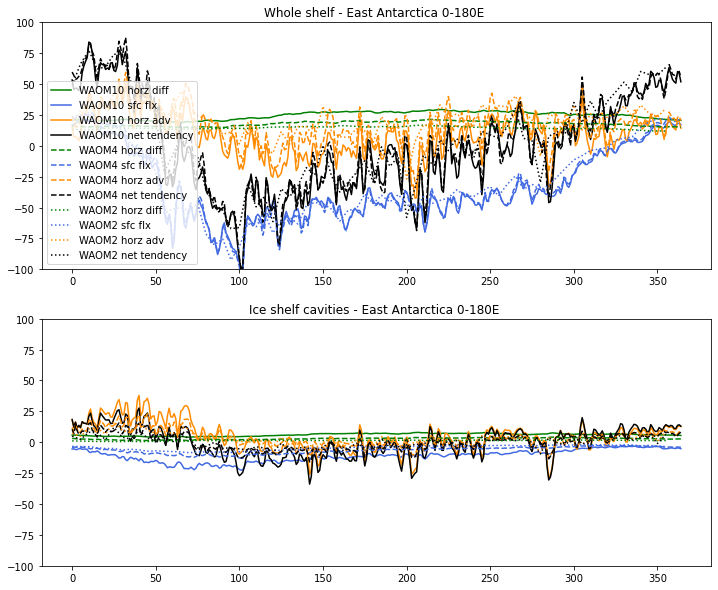

In [89]:
## same as above but splitting in West and East Antarctica:

# now get the last values (=circum-Antarctic integrated value) and plot over time to match with OHB figures:

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,1,1, frameon=True)

ax1.plot(np.arange(0,365,1),hdiff.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(np.arange(0,365,1),vdiff.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(np.arange(0,365,1),hadv.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax1.plot(np.arange(0,365,1),net.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax1.plot(np.arange(0,365,1),w4_hdiff.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(np.arange(0,365,1),w4_vdiff.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(np.arange(0,365,1),w4_hadv.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax1.plot(np.arange(0,365,1),w4_net.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax1.plot(np.arange(0,360,5),w2_hdiff.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(np.arange(0,360,5),w2_vdiff.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(np.arange(0,360,5),w2_hadv.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax1.plot(np.arange(0,360,5),w2_net.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax1.legend(loc='best')
ax1.set_title('Whole shelf - East Antarctica 0-180E ')
ax1.set_ylim(-100,100)

ax2 = fig.add_subplot(2,1,2, frameon=True)

ax2.plot(np.arange(0,365,1),hdiff_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,color='green',label='WAOM10 horz diff')
ax2.plot(np.arange(0,365,1),vdiff_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax2.plot(np.arange(0,365,1),hadv_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,color='darkorange',label='WAOM10 horz adv')
ax2.plot(np.arange(0,365,1),net_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,color='k',label='WAOM10 net tendency')

ax2.plot(np.arange(0,365,1),w4_hdiff_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax2.plot(np.arange(0,365,1),w4_vdiff_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax2.plot(np.arange(0,365,1),w4_hadv_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')
ax2.plot(np.arange(0,365,1),w4_net_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,'--',color='k',label='WAOM4 net tendency')

ax2.plot(np.arange(0,360,5),w2_hdiff_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,':',color='green',label='WAOM2 horz diff')
ax2.plot(np.arange(0,360,5),w2_vdiff_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax2.plot(np.arange(0,360,5),w2_hadv_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax2.plot(np.arange(0,360,5),w2_net_is.isel(lon_bins=slice(60,120)).sum('lon_bins')*1e-12,':',color='k',label='WAOM2 net tendency')
ax2.set_title('Ice shelf cavities - East Antarctica 0-180E ')
ax2.set_ylim(-100,100)

name_fig='waom10x4x2_lonbin_0-180E-integ_OHB_daily.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight', facecolor='white')

In [60]:
# print integrated values:

print('Whole shelf')

print('--- WAOM10 ---')
print('hdiff = ',hdiff.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('vdiff = ',vdiff.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('hadv = ',hadv.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('net = ',net.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')

print('--- WAOM4 ---')
print('hdiff = ',w4_hdiff.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('vdiff = ',w4_vdiff.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('hadv = ',w4_hadv.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('net = ',w4_net.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')

print('--- WAOM2 ---')
print('hdiff = ',w2_hdiff.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('vdiff = ',w2_vdiff.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('hadv = ',w2_hadv.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('net = ',w2_net.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')

print('--- WAOM4-NOTIDE ---')
print('hdiff = ',w4nt_hdiff.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('vdiff = ',w4nt_vdiff.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('hadv = ',w4nt_hadv.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('net = ',w4nt_net.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')




Whole shelf
--- WAOM10 ---
hdiff =  51.789796389992894 TW
vdiff =  -68.2681802812116 TW
hadv =  17.605490154928685 TW
net =  1.1271062692264575 TW
--- WAOM4 ---
hdiff =  36.60953771113034 TW
vdiff =  -63.88832086758374 TW
hadv =  30.386833262412203 TW
net =  3.1080500992559923 TW
--- WAOM2 ---
hdiff =  29.751376013030686 TW
vdiff =  -62.973448775657424 TW
hadv =  39.579574886607766 TW
net =  6.357502127010038 TW
--- WAOM4-NOTIDE ---
hdiff =  37.641926448178324 TW
vdiff =  -63.510524546675356 TW
hadv =  27.531467145224507 TW
net =  1.6628690418652021 TW


In [61]:
# print integrated values:

print('Ice shelf cavities')

print('--- WAOM10 ---')
print('hdiff = ',hdiff_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('vdiff = ',vdiff_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('hadv = ',hadv_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('net = ',net_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')

print('--- WAOM4 ---')
print('hdiff = ',w4_hdiff_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('vdiff = ',w4_vdiff_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('hadv = ',w4_hadv_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('net = ',w4_net_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')

print('--- WAOM2 ---')
print('hdiff = ',w2_hdiff_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('vdiff = ',w2_vdiff_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('hadv = ',w2_hadv_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('net = ',w2_net_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')

print('--- WAOM4-NOTIDE ---')
print('hdiff = ',w4nt_hdiff_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('vdiff = ',w4nt_vdiff_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('hadv = ',w4nt_hadv_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')
print('net = ',w4nt_net_is.mean('ocean_time').sum('lon_bins').values*1e-12,'TW')




Ice shelf cavities
--- WAOM10 ---
hdiff =  12.596820680247934 TW
vdiff =  -25.376649192625884 TW
hadv =  14.049441138122438 TW
net =  1.2696126261120488 TW
--- WAOM4 ---
hdiff =  5.543787022128101 TW
vdiff =  -14.067426698287852 TW
hadv =  9.401208850893703 TW
net =  0.8775691776840466 TW
--- WAOM2 ---
hdiff =  2.9066105146113816 TW
vdiff =  -11.21168391819646 TW
hadv =  9.08077343607191 TW
net =  0.7757000306418208 TW
--- WAOM4-NOTIDE ---
hdiff =  5.205947009572276 TW
vdiff =  -14.491625172926012 TW
hadv =  9.541340653004198 TW
net =  0.2556624904084053 TW


### Plot figures with all expts:

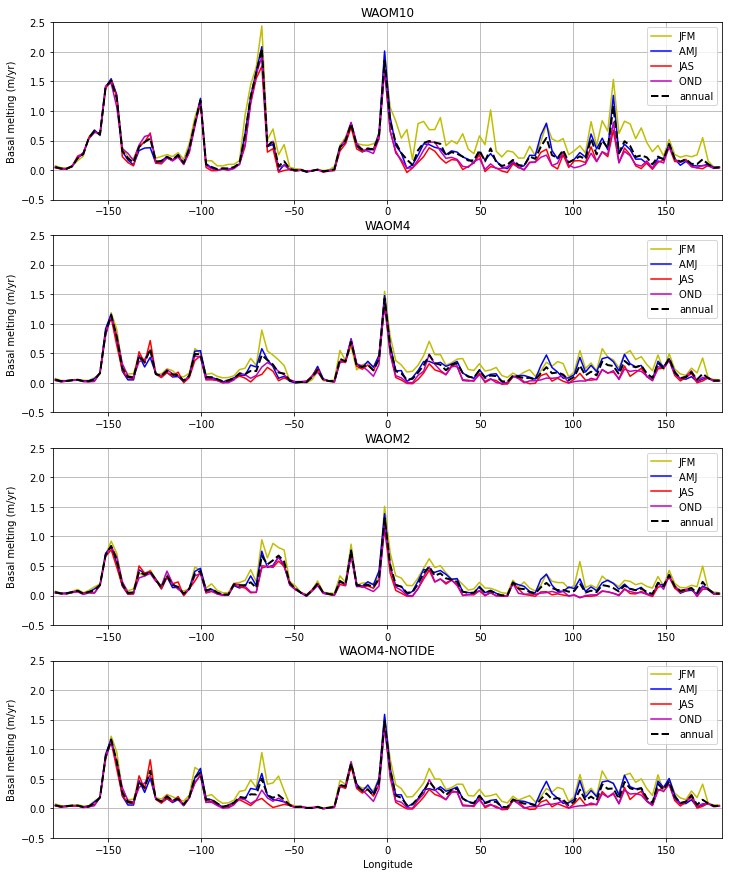

In [62]:
# seasonality basal melting:


fig = plt.figure(figsize=(12,15))
ax2 = fig.add_subplot(4,1,1, frameon=True)
# seasonal
ax2.plot(lon_bins,np.divide(np.nanmean(bmelt.isel(ocean_time=slice(s1i,s1e)), axis=0),area_sum.values)*1000,'-y',label='JFM ')
ax2.plot(lon_bins,np.divide(np.nanmean(bmelt.isel(ocean_time=slice(s2i,s2e)), axis=0),area_sum.values)*1000,'-b',label='AMJ ')
ax2.plot(lon_bins,np.divide(np.nanmean(bmelt.isel(ocean_time=slice(s3i,s3e)), axis=0),area_sum.values)*1000,'-r',label='JAS ')
ax2.plot(lon_bins,np.divide(np.nanmean(bmelt.isel(ocean_time=slice(s4i,s4e)), axis=0),area_sum.values)*1000,'-m',label='OND ')
ax2.plot(lon_bins,np.divide(np.nanmean(bmelt, axis=0),area_sum.values)*1000,'--k',label='annual', linewidth=2)

ax2.legend()
# ax2.set_xlabel('Longitude')
ax2.set_ylabel('Basal melting (m/yr)')
ax2.set_title('WAOM10')
ax2.grid('on')
ax2.set_xlim(-180,180)
ax2.set_ylim(-.5,2.5)

ax2 = fig.add_subplot(4,1,2, frameon=True)
# seasonal
ax2.plot(lon_bins,np.divide(np.nanmean(w4_bmelt.isel(ocean_time=slice(s1i,s1e)), axis=0),area_sum.values)*1000,'-y',label='JFM ')
ax2.plot(lon_bins,np.divide(np.nanmean(w4_bmelt.isel(ocean_time=slice(s2i,s2e)), axis=0),area_sum.values)*1000,'-b',label='AMJ ')
ax2.plot(lon_bins,np.divide(np.nanmean(w4_bmelt.isel(ocean_time=slice(s3i,s3e)), axis=0),area_sum.values)*1000,'-r',label='JAS ')
ax2.plot(lon_bins,np.divide(np.nanmean(w4_bmelt.isel(ocean_time=slice(s4i,s4e)), axis=0),area_sum.values)*1000,'-m',label='OND ')
ax2.plot(lon_bins,np.divide(np.nanmean(w4_bmelt, axis=0),area_sum.values)*1000,'--k',label='annual', linewidth=2)

ax2.legend()
# ax2.set_xlabel('Longitude')
ax2.set_ylabel('Basal melting (m/yr)')
ax2.set_title('WAOM4')
ax2.grid('on')
ax2.set_xlim(-180,180)
ax2.set_ylim(-.5,2.5)

ax2 = fig.add_subplot(4,1,3, frameon=True)
# seasonal
ax2.plot(lon_bins,np.divide(np.nanmean(w2_bmelt.isel(ocean_time=slice(s1i_5d,s1e_5d)), axis=0),area_sum.values)*1000,'-y',label='JFM ')
ax2.plot(lon_bins,np.divide(np.nanmean(w2_bmelt.isel(ocean_time=slice(s2i_5d,s2e_5d)), axis=0),area_sum.values)*1000,'-b',label='AMJ ')
ax2.plot(lon_bins,np.divide(np.nanmean(w2_bmelt.isel(ocean_time=slice(s3i_5d,s3e_5d)), axis=0),area_sum.values)*1000,'-r',label='JAS ')
ax2.plot(lon_bins,np.divide(np.nanmean(w2_bmelt.isel(ocean_time=slice(s4i_5d,s4e_5d)), axis=0),area_sum.values)*1000,'-m',label='OND ')
ax2.plot(lon_bins,np.divide(np.nanmean(w2_bmelt, axis=0),area_sum.values)*1000,'--k',label='annual', linewidth=2)

ax2.legend()
# ax2.set_xlabel('Longitude')
ax2.set_ylabel('Basal melting (m/yr)')
ax2.set_title('WAOM2')
ax2.grid('on')
ax2.set_xlim(-180,180)
ax2.set_ylim(-.5,2.5)

ax2 = fig.add_subplot(4,1,4, frameon=True)
# seasonal
ax2.plot(lon_bins,np.divide(np.nanmean(w4nt_bmelt.isel(ocean_time=slice(s1i,s1e)), axis=0),area_sum.values)*1000,'-y',label='JFM ')
ax2.plot(lon_bins,np.divide(np.nanmean(w4nt_bmelt.isel(ocean_time=slice(s2i,s2e)), axis=0),area_sum.values)*1000,'-b',label='AMJ ')
ax2.plot(lon_bins,np.divide(np.nanmean(w4nt_bmelt.isel(ocean_time=slice(s3i,s3e)), axis=0),area_sum.values)*1000,'-r',label='JAS ')
ax2.plot(lon_bins,np.divide(np.nanmean(w4nt_bmelt.isel(ocean_time=slice(s4i,s4e)), axis=0),area_sum.values)*1000,'-m',label='OND ')
ax2.plot(lon_bins,np.divide(np.nanmean(w4nt_bmelt, axis=0),area_sum.values)*1000,'--k',label='annual', linewidth=2)

ax2.legend()
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Basal melting (m/yr)')
ax2.set_title('WAOM4-NOTIDE')
ax2.grid('on')
ax2.set_xlim(-180,180)
ax2.set_ylim(-.5,2.5)


name_fig='waom10x4x4NTx2_lonbin_regional_Basal_melt_seasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


Seasonality in the basal melting is larger at East Antarctica + Maud region. Most places have higher melting in summer (JFM) and lower in winter (JAS/OND)
- one exception is at 130W (Getz?) region, where melting is lower in AMJ.

(-3.0, 3.0)

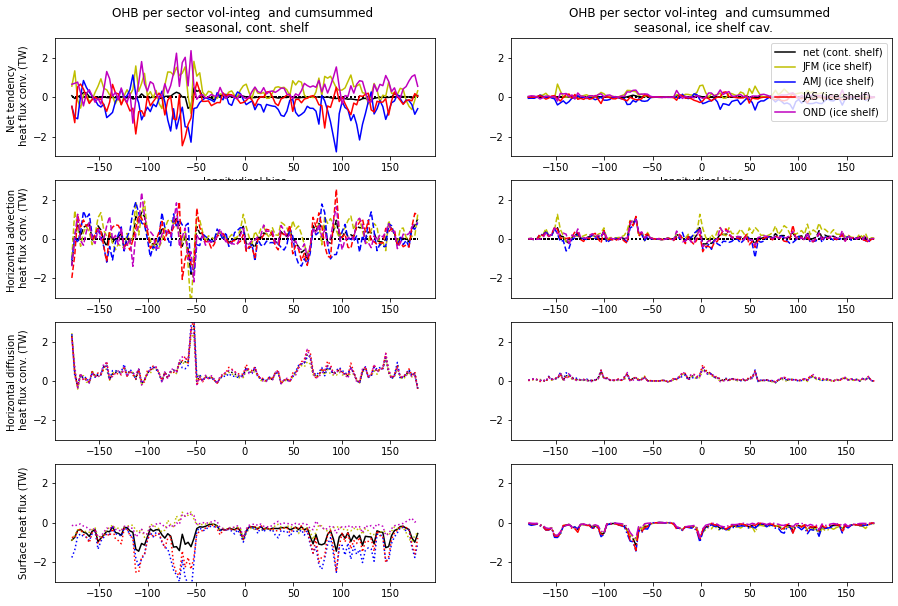

In [63]:
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(421)# projection=proj)
ax1.plot(lon_bins,(net)*0,':k')
ax1.plot(lon_bins,(net).mean('ocean_time')*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'m',label='OND (cont. shelf)')
# ax1.plot(lon_bins,(net).mean('ocean_time')*1e-12,'-k',label='net (cont. shelf)')
# ax1.plot(lon_bins,(net).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'y',label='JFM (cont. shelf)')
# ax1.plot(lon_bins,(net).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'b',label='AMJ (cont. shelf)')
# ax1.plot(lon_bins,(net).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'r',label='JAS (cont. shelf)')
# ax1.plot(lon_bins,(net).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'m',label='OND (cont. shelf)')
# ax1.legend()
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('Net tendency \n heat flux conv. (TW)')
ax1.set_title('OHB per sector vol-integ  and cumsummed \n seasonal, cont. shelf')
ax1.set_ylim(-3,3)

ax2 = fig.add_subplot(423)# projection=proj)
ax2.plot(lon_bins,(net)*0,':k')
ax2.plot(lon_bins,(hadv).mean('ocean_time')*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'--m',label='hadv OND')
# ax2.plot(lon_bins,(hadv).mean('ocean_time')*1e-12,'--k',label='hadv')
# ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'--y',label='hadv JFM')
# ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'--b',label='hadv AMJ')
# ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'--r',label='hadv JAS')
# ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'--m',label='hadv OND')
ax2.set_ylabel('Horizontal advection \n heat flux conv. (TW)')
ax2.set_ylim(-3,3)

ax2b = fig.add_subplot(425)# projection=proj)
ax2b.plot(lon_bins,(hdiff).mean('ocean_time')*1e-12,':k',label='hdiff')
ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='hdiff JFM')
ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b',label='hdiff AMJ')
ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r',label='hdiff JAS')
ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m',label='hdiff OND')
# ax2b.plot(lon_bins,(hdiff).mean('ocean_time')*1e-12,':k',label='hdiff')
# ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='hdiff JFM')
# ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b',label='hdiff AMJ')
# ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r',label='hdiff JAS')
# ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m',label='hdiff OND')
ax2b.set_ylabel('Horizontal diffusion \n heat flux conv. (TW)')
ax2b.set_ylim(-3,3)

ax2c = fig.add_subplot(427)# projection=proj)
ax2c.plot(lon_bins,(vdiff).mean('ocean_time')*1e-12,'-k',label='shflux')
ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='shflux JFM')
ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b',label='shflux AMJ')
ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r',label='shflux JAS')
ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m',label='shflux OND')
# ax2c.plot(lon_bins,(vdiff).mean('ocean_time')*1e-12,'-k',label='shflux')
# ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='shflux JFM')
# ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b',label='shflux AMJ')
# ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r',label='shflux JAS')
# ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m',label='shflux OND')
ax2c.set_ylabel('Surface heat flux (TW)')
# ax2.set_title('OHB per sector vol-integ  and cumsummed \n annual + seasonal')
ax2c.set_ylim(-3,3)

ax3 = fig.add_subplot(422)# projection=proj)
ax3.plot(lon_bins,(net)*0,':k')
ax3.plot(lon_bins,(net_is).mean('ocean_time')*1e-12,'-k',label='net (cont. shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'y',label='JFM (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'b',label='AMJ (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'r',label='JAS (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'m',label='OND (ice shelf)')
ax3.legend()
ax3.set_xlabel('longitudinal bins')
# ax3.set_ylabel('heat flux conv. (TW)')
ax3.set_title('OHB per sector vol-integ  and cumsummed \n seasonal, ice shelf cav.')
ax3.set_ylim(-3,3)

ax4 = fig.add_subplot(424)# projection=proj)
ax4.plot(lon_bins,(net)*0,':k')
ax4.plot(lon_bins,(hadv_is).mean('ocean_time')*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'--m',label='hadv OND')
ax4.set_ylim(-3,3)

ax4b = fig.add_subplot(426)# projection=proj)
ax4b.plot(lon_bins,(hdiff_is).mean('ocean_time')*1e-12,':k',label='hdiff')
ax4b.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='hdiff JFM')
ax4b.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b')#,label='hdiff AMJ')
ax4b.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r')#,label='hdiff JAS')
ax4b.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m')#,label='hdiff OND')
ax4b.set_ylim(-3,3)

ax4c = fig.add_subplot(428)# projection=proj)
ax4c.plot(lon_bins,(vdiff_is).mean('ocean_time')*1e-12,'-.k',label='shflux')
ax4c.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'-.y',label='shflux JFM')
ax4c.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'-.b',label='shflux AMJ')
ax4c.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'-.r',label='shflux JAS')
ax4c.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'-.m',label='shflux OND')
# ax4c.legend(loc='lower left')
ax4c.set_ylim(-3,3)


(-3.0, 3.0)

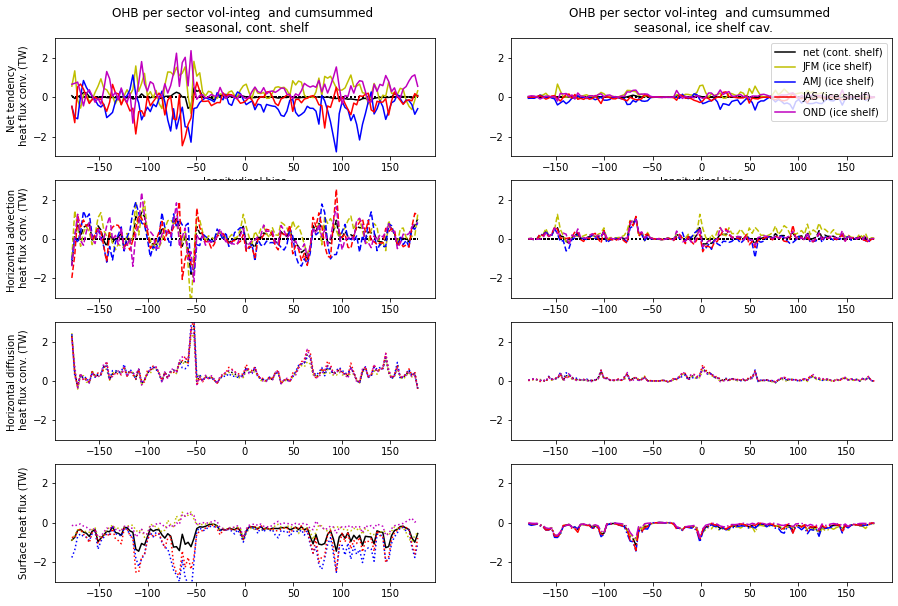

In [64]:
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(421)# projection=proj)
ax1.plot(lon_bins,(net)*0,':k')
ax1.plot(lon_bins,(net).mean('ocean_time')*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'m',label='OND (cont. shelf)')
# ax1.plot(lon_bins,(net).mean('ocean_time')*1e-12,'-k',label='net (cont. shelf)')
# ax1.plot(lon_bins,(net).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'y',label='JFM (cont. shelf)')
# ax1.plot(lon_bins,(net).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'b',label='AMJ (cont. shelf)')
# ax1.plot(lon_bins,(net).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'r',label='JAS (cont. shelf)')
# ax1.plot(lon_bins,(net).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'m',label='OND (cont. shelf)')
# ax1.legend()
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('Net tendency \n heat flux conv. (TW)')
ax1.set_title('OHB per sector vol-integ  and cumsummed \n seasonal, cont. shelf')
ax1.set_ylim(-3,3)

ax2 = fig.add_subplot(423)# projection=proj)
ax2.plot(lon_bins,(net)*0,':k')
ax2.plot(lon_bins,(hadv).mean('ocean_time')*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'--m',label='hadv OND')
# ax2.plot(lon_bins,(hadv).mean('ocean_time')*1e-12,'--k',label='hadv')
# ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'--y',label='hadv JFM')
# ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'--b',label='hadv AMJ')
# ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'--r',label='hadv JAS')
# ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'--m',label='hadv OND')
ax2.set_ylabel('Horizontal advection \n heat flux conv. (TW)')
ax2.set_ylim(-3,3)

ax2b = fig.add_subplot(425)# projection=proj)
ax2b.plot(lon_bins,(hdiff).mean('ocean_time')*1e-12,':k',label='hdiff')
ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='hdiff JFM')
ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b',label='hdiff AMJ')
ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r',label='hdiff JAS')
ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m',label='hdiff OND')
# ax2b.plot(lon_bins,(hdiff).mean('ocean_time')*1e-12,':k',label='hdiff')
# ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='hdiff JFM')
# ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b',label='hdiff AMJ')
# ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r',label='hdiff JAS')
# ax2b.plot(lon_bins,(hdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m',label='hdiff OND')
ax2b.set_ylabel('Horizontal diffusion \n heat flux conv. (TW)')
ax2b.set_ylim(-3,3)

ax2c = fig.add_subplot(427)# projection=proj)
ax2c.plot(lon_bins,(vdiff).mean('ocean_time')*1e-12,'-k',label='shflux')
ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='shflux JFM')
ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b',label='shflux AMJ')
ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r',label='shflux JAS')
ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m',label='shflux OND')
# ax2c.plot(lon_bins,(vdiff).mean('ocean_time')*1e-12,'-k',label='shflux')
# ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='shflux JFM')
# ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b',label='shflux AMJ')
# ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r',label='shflux JAS')
# ax2c.plot(lon_bins,(vdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m',label='shflux OND')
ax2c.set_ylabel('Surface heat flux (TW)')
# ax2.set_title('OHB per sector vol-integ  and cumsummed \n annual + seasonal')
ax2c.set_ylim(-3,3)

ax3 = fig.add_subplot(422)# projection=proj)
ax3.plot(lon_bins,(net)*0,':k')
ax3.plot(lon_bins,(net_is).mean('ocean_time')*1e-12,'-k',label='net (cont. shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'y',label='JFM (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'b',label='AMJ (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'r',label='JAS (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'m',label='OND (ice shelf)')
ax3.legend()
ax3.set_xlabel('longitudinal bins')
# ax3.set_ylabel('heat flux conv. (TW)')
ax3.set_title('OHB per sector vol-integ  and cumsummed \n seasonal, ice shelf cav.')
ax3.set_ylim(-3,3)

ax4 = fig.add_subplot(424)# projection=proj)
ax4.plot(lon_bins,(net)*0,':k')
ax4.plot(lon_bins,(hadv_is).mean('ocean_time')*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'--m',label='hadv OND')
ax4.set_ylim(-3,3)

ax4b = fig.add_subplot(426)# projection=proj)
ax4b.plot(lon_bins,(hdiff_is).mean('ocean_time')*1e-12,':k',label='hdiff')
ax4b.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,':y',label='hdiff JFM')
ax4b.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,':b')#,label='hdiff AMJ')
ax4b.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,':r')#,label='hdiff JAS')
ax4b.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,':m')#,label='hdiff OND')
ax4b.set_ylim(-3,3)

ax4c = fig.add_subplot(428)# projection=proj)
ax4c.plot(lon_bins,(vdiff_is).mean('ocean_time')*1e-12,'-.k',label='shflux')
ax4c.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time')*1e-12,'-.y',label='shflux JFM')
ax4c.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time')*1e-12,'-.b',label='shflux AMJ')
ax4c.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time')*1e-12,'-.r',label='shflux JAS')
ax4c.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time')*1e-12,'-.m',label='shflux OND')
# ax4c.legend(loc='lower left')
ax4c.set_ylim(-3,3)


WAOM10 Seasonality in the ocean processes:
- the heat tendency is usually a balance between warming (OND-JFM) and cooling (AMJ-JAS). Both cont shelf & IScavit
- SHF has lots of seasonality at the shelf, but almost none inside the IScavit (always cooling due to meltwater)
- Horz diff always warm, generally peaks where SHF peaks (sfc induces stronger cross-shelf grad?)
- Horiz advection has lots of variability in both cont shelf and IScavit
  - dominates seasonal variability in the IScavit
  - w/ likely important contrib in the cont shelf too
    - seems imporant b/w (~) 50W:50E (no coastal polynyas)
    - while SHF more imokrtant at West/East Antarctica (where has large polynyas)
- How these compare with 4/2km?
  - & without tides?

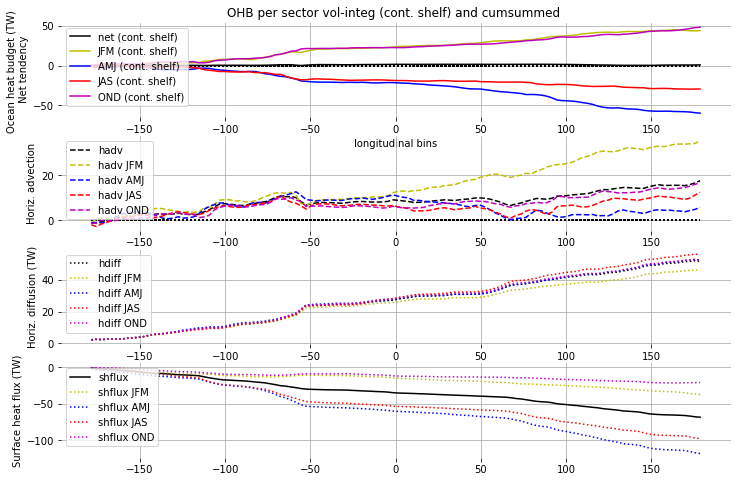

In [65]:
fig = plt.figure(figsize=(12,8))

# Original WAOM10
ax1 = fig.add_subplot(411, frameon=False)
ax1.plot(lon_bins,(net)*0,':k')
ax1.plot(lon_bins,(net).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(net).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (cont. shelf)')
ax1.legend(loc='upper left')
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('Ocean heat budget (TW) \n Net tendency')
ax1.set_title('OHB per sector vol-integ (cont. shelf) and cumsummed ')
ax1.grid('on')

ax2 = fig.add_subplot(412, frameon=False)
ax2.plot(lon_bins,(net)*0,':k')
ax2.plot(lon_bins,(hadv).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(hadv).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax2.legend(loc='upper left')
ax2.grid('on')
ax2.set_ylabel('Horiz. advection')

ax3 = fig.add_subplot(413, frameon=False)
ax3.plot(lon_bins,(hdiff).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax3.plot(lon_bins,(hdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax3.plot(lon_bins,(hdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax3.plot(lon_bins,(hdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax3.plot(lon_bins,(hdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax3.legend(loc='upper left')
ax3.grid('on')
ax3.set_ylabel('Horiz. diffusion (TW)')

ax4 = fig.add_subplot(414, frameon=False)
ax4.plot(lon_bins,(vdiff).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax4.plot(lon_bins,(vdiff).isel(ocean_time=slice(s1i,s1e)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax4.plot(lon_bins,(vdiff).isel(ocean_time=slice(s2i,s2e)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax4.plot(lon_bins,(vdiff).isel(ocean_time=slice(s3i,s3e)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax4.plot(lon_bins,(vdiff).isel(ocean_time=slice(s4i,s4e)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
ax4.legend(loc='upper left')
ax4.grid('on')
ax4.set_ylabel('Surface heat flux (TW)')


name_fig='waom10_lonbin_regional_OHBseasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


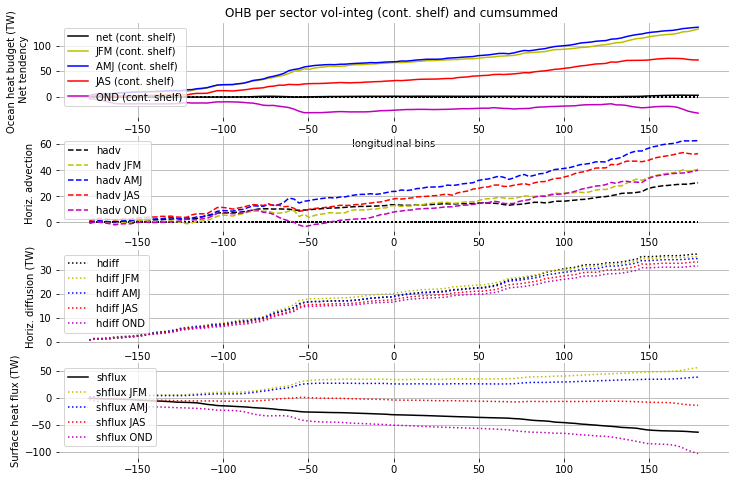

In [66]:
fig = plt.figure(figsize=(12,8))

# Original WAOM4
ax1 = fig.add_subplot(411, frameon=False)
ax1.plot(lon_bins,(net)*0,':k')
ax1.plot(lon_bins,(w4_net).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(w4_net).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(w4_net).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(w4_net).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(w4_net).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (cont. shelf)')
ax1.legend(loc='upper left')
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('Ocean heat budget (TW) \n Net tendency')
ax1.set_title('OHB per sector vol-integ (cont. shelf) and cumsummed ')
ax1.grid('on')

ax2 = fig.add_subplot(412, frameon=False)
ax2.plot(lon_bins,(net)*0,':k')
ax2.plot(lon_bins,(w4_hadv).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(w4_hadv).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(w4_hadv).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(w4_hadv).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(w4_hadv).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax2.legend(loc='upper left')
ax2.grid('on')
ax2.set_ylabel('Horiz. advection')

ax3 = fig.add_subplot(413, frameon=False)
ax3.plot(lon_bins,(w4_hdiff).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax3.plot(lon_bins,(w4_hdiff).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax3.plot(lon_bins,(w4_hdiff).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax3.plot(lon_bins,(w4_hdiff).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax3.plot(lon_bins,(w4_hdiff).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax3.legend(loc='upper left')
ax3.grid('on')
ax3.set_ylabel('Horiz. diffusion (TW)')

ax4 = fig.add_subplot(414, frameon=False)
ax4.plot(lon_bins,(w4_vdiff).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax4.plot(lon_bins,(w4_vdiff).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax4.plot(lon_bins,(w4_vdiff).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax4.plot(lon_bins,(w4_vdiff).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax4.plot(lon_bins,(w4_vdiff).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
ax4.legend(loc='upper left')
ax4.grid('on')
ax4.set_ylabel('Surface heat flux (TW)')


name_fig='waom4_lonbin_regional_OHBseasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')
plt.show()

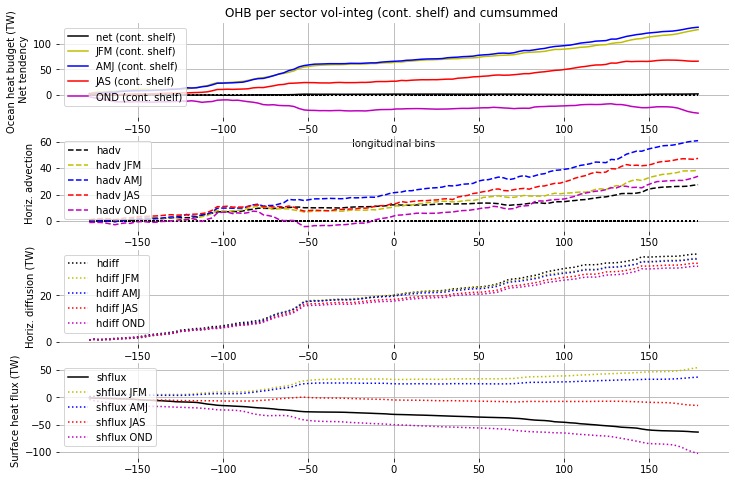

In [67]:
fig = plt.figure(figsize=(12,8))

# Original WAOM4-NT
ax1 = fig.add_subplot(411, frameon=False)
ax1.plot(lon_bins,(net)*0,':k')
ax1.plot(lon_bins,(w4nt_net).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(w4nt_net).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(w4nt_net).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(w4nt_net).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(w4nt_net).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (cont. shelf)')
ax1.legend(loc='upper left')
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('Ocean heat budget (TW) \n Net tendency')
ax1.set_title('OHB per sector vol-integ (cont. shelf) and cumsummed ')
ax1.grid('on')

ax2 = fig.add_subplot(412, frameon=False)
ax2.plot(lon_bins,(net)*0,':k')
ax2.plot(lon_bins,(w4nt_hadv).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(w4nt_hadv).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(w4nt_hadv).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(w4nt_hadv).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(w4nt_hadv).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax2.legend(loc='upper left')
ax2.grid('on')
ax2.set_ylabel('Horiz. advection')

ax3 = fig.add_subplot(413, frameon=False)
ax3.plot(lon_bins,(w4nt_hdiff).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax3.plot(lon_bins,(w4nt_hdiff).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax3.plot(lon_bins,(w4nt_hdiff).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax3.plot(lon_bins,(w4nt_hdiff).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax3.plot(lon_bins,(w4nt_hdiff).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax3.legend(loc='upper left')
ax3.grid('on')
ax3.set_ylabel('Horiz. diffusion (TW)')

ax4 = fig.add_subplot(414, frameon=False)
ax4.plot(lon_bins,(w4nt_vdiff).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax4.plot(lon_bins,(w4nt_vdiff).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax4.plot(lon_bins,(w4nt_vdiff).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax4.plot(lon_bins,(w4nt_vdiff).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax4.plot(lon_bins,(w4nt_vdiff).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
ax4.legend(loc='upper left')
ax4.grid('on')
ax4.set_ylabel('Surface heat flux (TW)')


name_fig='waom4-notides_lonbin_regional_OHBseasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


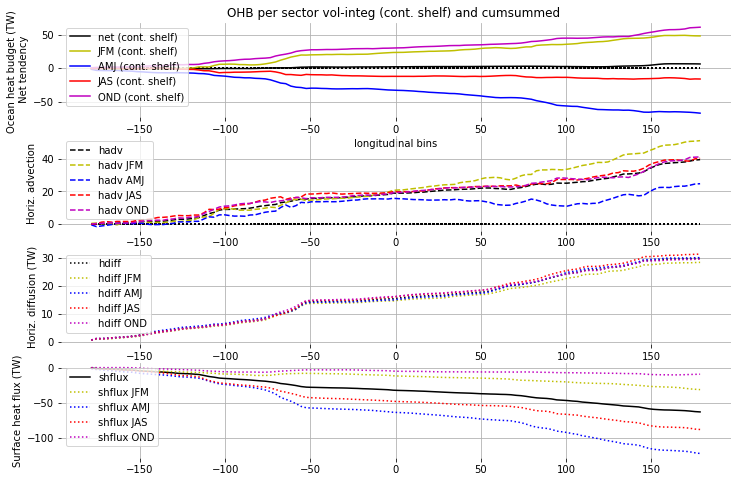

In [68]:
fig = plt.figure(figsize=(12,8))

# Original WAOM4
ax1 = fig.add_subplot(411, frameon=False)
ax1.plot(lon_bins,(net)*0,':k')
ax1.plot(lon_bins,(w2_net).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(w2_net).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(w2_net).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(w2_net).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(w2_net).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (cont. shelf)')
ax1.legend(loc='upper left')
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('Ocean heat budget (TW) \n Net tendency')
ax1.set_title('OHB per sector vol-integ (cont. shelf) and cumsummed ')
ax1.grid('on')

ax2 = fig.add_subplot(412, frameon=False)
ax2.plot(lon_bins,(net)*0,':k')
ax2.plot(lon_bins,(w2_hadv).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(w2_hadv).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(w2_hadv).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(w2_hadv).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(w2_hadv).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax2.legend(loc='upper left')
ax2.grid('on')
ax2.set_ylabel('Horiz. advection')

ax3 = fig.add_subplot(413, frameon=False)
ax3.plot(lon_bins,(w2_hdiff).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax3.plot(lon_bins,(w2_hdiff).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax3.plot(lon_bins,(w2_hdiff).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax3.plot(lon_bins,(w2_hdiff).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax3.plot(lon_bins,(w2_hdiff).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax3.legend(loc='upper left')
ax3.grid('on')
ax3.set_ylabel('Horiz. diffusion (TW)')

ax4 = fig.add_subplot(414, frameon=False)
ax4.plot(lon_bins,(w2_vdiff).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax4.plot(lon_bins,(w2_vdiff).isel(ocean_time=slice(s1i_5d,s1e_5d)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax4.plot(lon_bins,(w2_vdiff).isel(ocean_time=slice(s2i_5d,s2e_5d)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax4.plot(lon_bins,(w2_vdiff).isel(ocean_time=slice(s3i_5d,s3e_5d)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax4.plot(lon_bins,(w2_vdiff).isel(ocean_time=slice(s4i_5d,s4e_5d)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
ax4.legend(loc='upper left')
ax4.grid('on')
ax4.set_ylabel('Surface heat flux (TW)')


name_fig='waom2_lonbin_regional_OHBseasonal.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')
plt.show()

#### Final figs

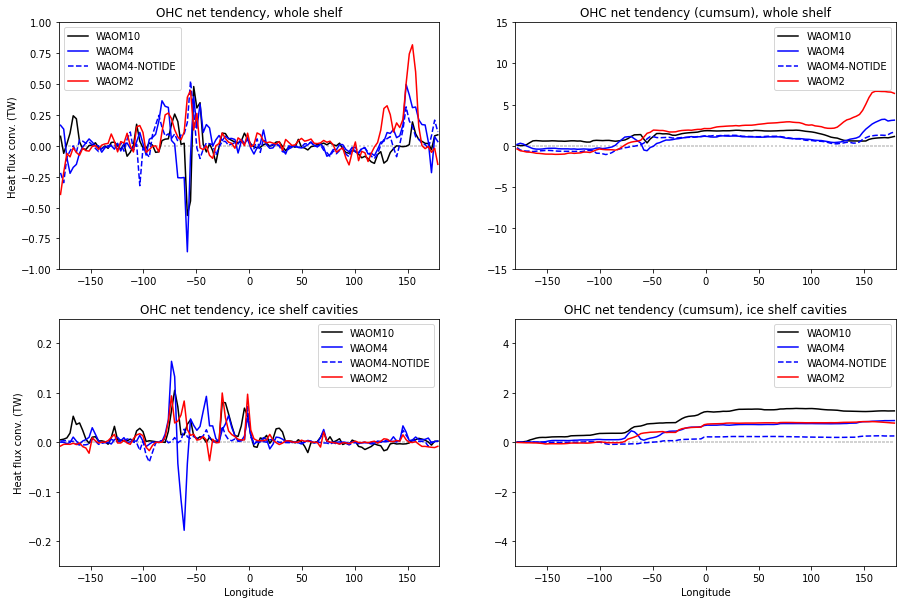

In [69]:
# 1 - OHC drift across expts and comparison whole shelf x IScavities:

fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(222)# projection=proj)
ax1.plot(lon_bins,(net)*0,':',color='lightgray')
ax1.plot(lon_bins,(net).mean('ocean_time').cumsum()*1e-12,'-k',label='WAOM10')
ax1.plot(lon_bins,(w4_net).mean('ocean_time').cumsum()*1e-12,'-b',label='WAOM4')
ax1.plot(lon_bins,(w4nt_net).mean('ocean_time').cumsum()*1e-12,'--b',label='WAOM4-NOTIDE')
ax1.plot(lon_bins,(w2_net).mean('ocean_time').cumsum()*1e-12,'-r',label='WAOM2')
ax1.legend()
# ax1.set_xlabel('Longitude')
# ax1.set_ylabel('Heat flux conv. (TW)')
ax1.set_title('OHC net tendency (cumsum), whole shelf')
ax1.set_ylim(-15,15)
ax1.set_xlim(-180,180)

ax1 = fig.add_subplot(221)# projection=proj)
ax1.plot(lon_bins,(net)*0,':',color='lightgray')
ax1.plot(lon_bins,(net).mean('ocean_time')*1e-12,'-k',label='WAOM10')
ax1.plot(lon_bins,(w4_net).mean('ocean_time')*1e-12,'-b',label='WAOM4')
ax1.plot(lon_bins,(w4nt_net).mean('ocean_time')*1e-12,'--b',label='WAOM4-NOTIDE')
ax1.plot(lon_bins,(w2_net).mean('ocean_time')*1e-12,'-r',label='WAOM2')
ax1.legend()
# ax1.set_xlabel('Longitude')
ax1.set_ylabel('Heat flux conv. (TW)')
ax1.set_title('OHC net tendency, whole shelf')
ax1.set_ylim(-1,1)
ax1.set_xlim(-180,180)

ax1 = fig.add_subplot(224)# projection=proj)
ax1.plot(lon_bins,(net)*0,':',color='lightgray')
ax1.plot(lon_bins,(net_is).mean('ocean_time').cumsum()*1e-12,'-k',label='WAOM10')
ax1.plot(lon_bins,(w4_net_is).mean('ocean_time').cumsum()*1e-12,'-b',label='WAOM4')
ax1.plot(lon_bins,(w4nt_net_is).mean('ocean_time').cumsum()*1e-12,'--b',label='WAOM4-NOTIDE')
ax1.plot(lon_bins,(w2_net_is).mean('ocean_time').cumsum()*1e-12,'-r',label='WAOM2')
ax1.legend()
ax1.set_xlabel('Longitude')
# ax1.set_ylabel('Heat flux conv. (TW)')
ax1.set_title('OHC net tendency (cumsum), ice shelf cavities')
ax1.set_ylim(-5,5)
ax1.set_xlim(-180,180)

ax1 = fig.add_subplot(223)# projection=proj)
ax1.plot(lon_bins,(net)*0,':',color='lightgray')
ax1.plot(lon_bins,(net_is).mean('ocean_time')*1e-12,'-k',label='WAOM10')
ax1.plot(lon_bins,(w4_net_is).mean('ocean_time')*1e-12,'-b',label='WAOM4')
ax1.plot(lon_bins,(w4nt_net_is).mean('ocean_time')*1e-12,'--b',label='WAOM4-NOTIDE')
ax1.plot(lon_bins,(w2_net_is).mean('ocean_time')*1e-12,'-r',label='WAOM2')
ax1.legend()
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Heat flux conv. (TW)')
ax1.set_title('OHC net tendency, ice shelf cavities')
ax1.set_ylim(-.25,.25)
ax1.set_xlim(-180,180)

name_fig='waom10x4x4NTx2_lonbin_regional_OHB_tendency_comparison.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight',facecolor='white')
# plt.show()

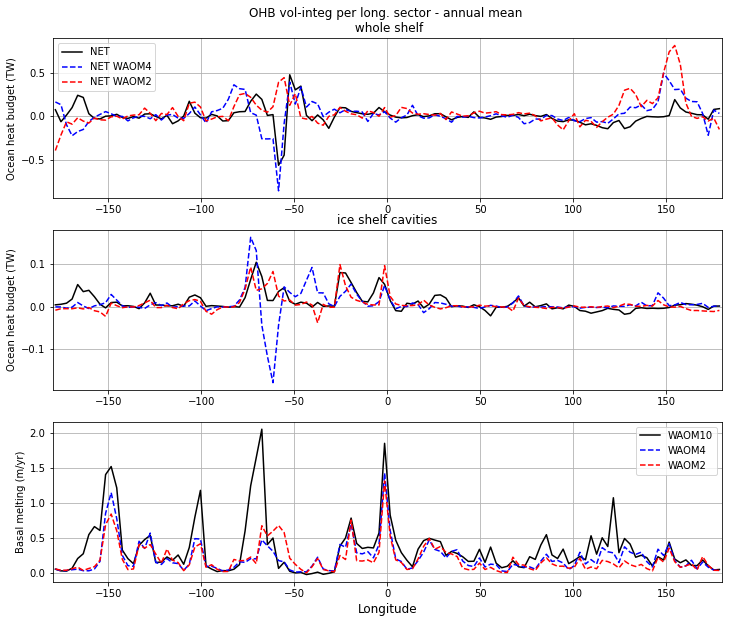

In [70]:

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(3,1,1, frameon=True)
# ax1.plot(lon_bins,(net)*0,':k')
#--using 10km daily:
# ax1.plot(lon_bins,(vdiff).mean('ocean_time')*1e-12,'-',color='b',label='SHF')
# ax1.plot(lon_bins,(hadv).mean('ocean_time')*1e-12,'-',color='orange',label='ADV')
# ax1.plot(lon_bins,(hdiff).mean('ocean_time')*1e-12,'-',color='green',label='DIFF')
ax1.plot(lon_bins,(net).mean('ocean_time')*1e-12,'-',color='k',label='NET')
#--using 10km 5-daily:
# ax1.plot(lon_bins,(vdiff_5d).mean('ocean_time')*1e-12,'--',color='b',label='SHF WAOM10')
# ax1.plot(lon_bins,(hadv_5d).mean('ocean_time')*1e-12,'--',color='orange',label='ADV WAOM10')
# ax1.plot(lon_bins,(hdiff_5d).mean('ocean_time')*1e-12,'--',color='green',label='DIFF WAOM10')
# ax1.plot(lon_bins,(net_5d).mean('ocean_time')*1e-12,'--',color='red',label='NET WAOM10')
#--using 4km 5-daily:
# ax1.plot(lon_bins,(w4_vdiff).mean('ocean_time')*1e-12,':',color='b',label='SHF WAOM4')
# ax1.plot(lon_bins,(w4_hadv).mean('ocean_time')*1e-12,':',color='orange',label='ADV WAOM4')
# ax1.plot(lon_bins,(w4_hdiff).mean('ocean_time')*1e-12,':',color='green',label='DIFF WAOM4')
ax1.plot(lon_bins,(w4_net).mean('ocean_time')*1e-12,'--',color='b',label='NET WAOM4')
#--using 2km 5-daily:
# ax1.plot(lon_bins,(w2_vdiff).mean('ocean_time')*1e-12,'-.',color='b',label='SHF WAOM2')
# ax1.plot(lon_bins,(w2_hadv).mean('ocean_time')*1e-12,'-.',color='orange',label='ADV WAOM2')
# ax1.plot(lon_bins,(w2_hdiff).mean('ocean_time')*1e-12,'-.',color='green',label='DIFF WAOM2')
ax1.plot(lon_bins,(w2_net).mean('ocean_time')*1e-12,'--',color='r',label='NET WAOM2')
ax1.legend()
# ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('Ocean heat budget (TW)')
ax1.set_title('OHB vol-integ per long. sector - annual mean \n whole shelf')
ax1.grid('on')
ax1.set_xlim(-180,180)

ax1 = fig.add_subplot(3,1,2, frameon=True)
# ax1.plot(lon_bins,(net_is)*0,':k')
#--using 10km daily:
# ax1.plot(lon_bins,(vdiff_is).mean('ocean_time')*1e-12,'-',color='b',label='SHF')
# ax1.plot(lon_bins,(hadv_is).mean('ocean_time')*1e-12,'-',color='orange',label='ADV')
# ax1.plot(lon_bins,(hdiff_is).mean('ocean_time')*1e-12,'-',color='green',label='DIFF')
ax1.plot(lon_bins,(net_is).mean('ocean_time')*1e-12,'-',color='k',label='NET WAOM10')
#--using 10km 5-daily:
# ax1.plot(lon_bins,(vdiff_5d).mean('ocean_time')*1e-12,'--',color='b',label='SHF WAOM10')
# ax1.plot(lon_bins,(hadv_5d).mean('ocean_time')*1e-12,'--',color='orange',label='ADV WAOM10')
# ax1.plot(lon_bins,(hdiff_5d).mean('ocean_time')*1e-12,'--',color='green',label='DIFF WAOM10')
# ax1.plot(lon_bins,(net_5d).mean('ocean_time')*1e-12,'--',color='red',label='NET WAOM10')
#--using 4km 5-daily:
# ax1.plot(lon_bins,(w4_vdiff_is).mean('ocean_time')*1e-12,':',color='b',label='SHF WAOM4')
# ax1.plot(lon_bins,(w4_hadv_is).mean('ocean_time')*1e-12,':',color='orange',label='ADV WAOM4')
# ax1.plot(lon_bins,(w4_hdiff_is).mean('ocean_time')*1e-12,':',color='green',label='DIFF WAOM4')
ax1.plot(lon_bins,(w4_net_is).mean('ocean_time')*1e-12,'--',color='b',label='NET WAOM4')
#--using 2km 5-daily:
# ax1.plot(lon_bins,(w2_vdiff_is).mean('ocean_time')*1e-12,':',color='b',label='SHF WAOM2')
# ax1.plot(lon_bins,(w2_hadv_is).mean('ocean_time')*1e-12,':',color='orange',label='ADV WAOM2')
# ax1.plot(lon_bins,(w2_hdiff_is).mean('ocean_time')*1e-12,':',color='green',label='DIFF WAOM2')
ax1.plot(lon_bins,(w2_net_is).mean('ocean_time')*1e-12,'--',color='r',label='NET WAOM2')
ax1.set_title('ice shelf cavities')
ax1.set_ylabel('Ocean heat budget (TW)')
ax1.set_xlim(-180,180)
ax1.grid('on')

ax2 = fig.add_subplot(3,1,3, frameon=True)
ax2.plot(lon_bins,np.divide(np.nanmean(bmelt, axis=0),area_sum.values)*1000,'-k',label='WAOM10')
ax2.plot(lon_bins,np.divide(np.nanmean(w4_bmelt, axis=0),area_sum.values)*1000,'--b',label='WAOM4')
ax2.plot(lon_bins,np.divide(np.nanmean(w2_bmelt, axis=0),area_sum.values)*1000,'--r',label='WAOM2')
ax2.set_xlabel('Longitude',fontsize=12)
ax2.set_ylabel('Basal melting (m/yr)')
ax2.grid('on')
ax2.set_xlim(-180,180)
ax2.legend()

name_fig='waom10x4x2_lonbin_regional_OHBnet+basal_melt.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight',facecolor='white')


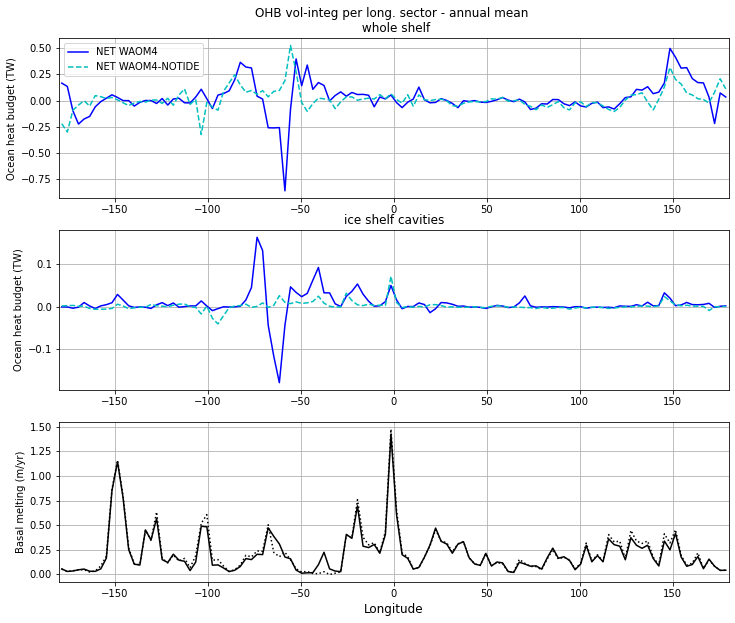

In [71]:

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(3,1,1)
# ax1.plot(lon_bins,(net)*0,':k')
#--using 4km 5-daily:
# ax1.plot(lon_bins,(w4_vdiff).mean('ocean_time')*1e-12,'-',color='b',label='SHF WAOM4')
# ax1.plot(lon_bins,(w4_hadv).mean('ocean_time')*1e-12,'-',color='orange',label='ADV WAOM4')
# ax1.plot(lon_bins,(w4_hdiff).mean('ocean_time')*1e-12,'-',color='green',label='DIFF WAOM4')
ax1.plot(lon_bins,(w4_net).mean('ocean_time')*1e-12,'-',color='b',label='NET WAOM4')
# ax1.plot(lon_bins,(w4nt_vdiff).mean('ocean_time')*1e-12,':',color='b',label='SHF WAOM4-NOTIDE')
# ax1.plot(lon_bins,(w4nt_hadv).mean('ocean_time')*1e-12,':',color='orange',label='ADV WAOM4-NOTIDE')
# ax1.plot(lon_bins,(w4nt_hdiff).mean('ocean_time')*1e-12,':',color='green',label='DIFF WAOM4-NOTIDE')
ax1.plot(lon_bins,(w4nt_net).mean('ocean_time')*1e-12,'--',color='c',label='NET WAOM4-NOTIDE')
ax1.legend()
# ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('Ocean heat budget (TW)')
ax1.set_title('OHB vol-integ per long. sector - annual mean \n whole shelf')
ax1.grid('on')
ax1.set_xlim(-180,180)

ax1 = fig.add_subplot(3,1,2)
# ax1.plot(lon_bins,(w4_vdiff_is).mean('ocean_time')*1e-12,'-',color='b',label='SHF WAOM4')
# ax1.plot(lon_bins,(w4_hadv_is).mean('ocean_time')*1e-12,'-',color='orange',label='ADV WAOM4')
# ax1.plot(lon_bins,(w4_hdiff_is).mean('ocean_time')*1e-12,'-',color='green',label='DIFF WAOM4')
ax1.plot(lon_bins,(w4_net_is).mean('ocean_time')*1e-12,'-',color='b',label='NET WAOM4')
# ax1.plot(lon_bins,(w4nt_vdiff_is).mean('ocean_time')*1e-12,':',color='b',label='SHF WAOM4-NOTIDE')
# ax1.plot(lon_bins,(w4nt_hadv_is).mean('ocean_time')*1e-12,':',color='orange',label='ADV WAOM4-NOTIDE')
# ax1.plot(lon_bins,(w4nt_hdiff_is).mean('ocean_time')*1e-12,':',color='green',label='DIFF WAOM4-NOTIDE')
ax1.plot(lon_bins,(w4nt_net_is).mean('ocean_time')*1e-12,'--',color='c',label='NET WAOM4-NOTIDE')
# ax1.legend()
# ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('Ocean heat budget (TW)')
ax1.set_title('ice shelf cavities')
ax1.grid('on')
ax1.set_xlim(-180,180)

ax2 = fig.add_subplot(3,1,3)
# ax2.plot(lon_bins,np.divide(np.nanmean(bmelt, axis=0),area_sum.values)*1000,'-k')
ax2.plot(lon_bins,np.divide(np.nanmean(w4_bmelt, axis=0),area_sum.values)*1000,'-k',label='WAOM4')
ax2.plot(lon_bins,np.divide(np.nanmean(w4nt_bmelt, axis=0),area_sum.values)*1000,':k',label='WAOM4-NOTIDE')
ax2.set_xlabel('Longitude',fontsize=12)
ax2.set_ylabel('Basal melting (m/yr)')
ax2.grid('on')
ax2.set_xlim(-180,180)

name_fig='waom4x4NT_lonbin_regional_OHBnet+basal_melt.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight',facecolor='white')


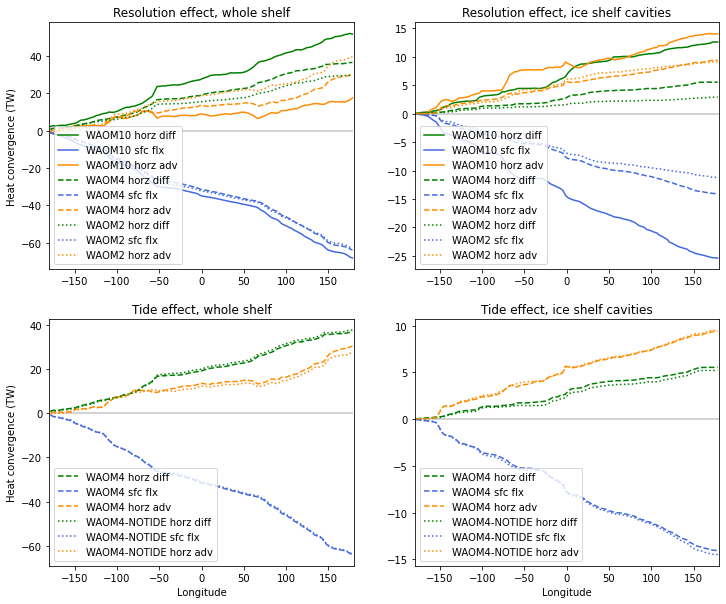

In [72]:
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(lon_bins,(net)*0,'-', color='lightgray')
ax1.plot(lon_bins,hdiff.mean('ocean_time').cumsum()*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(lon_bins,vdiff.mean('ocean_time').cumsum()*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(lon_bins,hadv.mean('ocean_time').cumsum()*1e-12,color='darkorange',label='WAOM10 horz adv')

ax1.plot(lon_bins,w4_hdiff.mean('ocean_time').cumsum()*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(lon_bins,w4_vdiff.mean('ocean_time').cumsum()*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(lon_bins,w4_hadv.mean('ocean_time').cumsum()*1e-12,'--',color='darkorange',label='WAOM4 horz adv')

ax1.plot(lon_bins,w2_hdiff.mean('ocean_time').cumsum()*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(lon_bins,w2_vdiff.mean('ocean_time').cumsum()*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(lon_bins,w2_hadv.mean('ocean_time').cumsum()*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_title('Resolution effect, whole shelf')
ax1.set_ylabel('Heat convergence (TW)')

ax1 = fig.add_subplot(2,2,2)
ax1.plot(lon_bins,(net_is)*0,'-', color='lightgray')
ax1.plot(lon_bins,hdiff_is.mean('ocean_time').cumsum()*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(lon_bins,vdiff_is.mean('ocean_time').cumsum()*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(lon_bins,hadv_is.mean('ocean_time').cumsum()*1e-12,color='darkorange',label='WAOM10 horz adv')

ax1.plot(lon_bins,w4_hdiff_is.mean('ocean_time').cumsum()*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(lon_bins,w4_vdiff_is.mean('ocean_time').cumsum()*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(lon_bins,w4_hadv_is.mean('ocean_time').cumsum()*1e-12,'--',color='darkorange',label='WAOM4 horz adv')

ax1.plot(lon_bins,w2_hdiff_is.mean('ocean_time').cumsum()*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(lon_bins,w2_vdiff_is.mean('ocean_time').cumsum()*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(lon_bins,w2_hadv_is.mean('ocean_time').cumsum()*1e-12,':',color='darkorange',label='WAOM2 horz adv')
ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_title('Resolution effect, ice shelf cavities')

ax1 = fig.add_subplot(2,2,3)

ax1.plot(lon_bins,(net_is)*0,'-', color='lightgray')
ax1.plot(lon_bins,w4_hdiff.mean('ocean_time').cumsum()*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(lon_bins,w4_vdiff.mean('ocean_time').cumsum()*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(lon_bins,w4_hadv.mean('ocean_time').cumsum()*1e-12,'--',color='darkorange',label='WAOM4 horz adv')

ax1.plot(lon_bins,w4nt_hdiff.mean('ocean_time').cumsum()*1e-12,':',color='green',label='WAOM4-NOTIDE horz diff')
ax1.plot(lon_bins,w4nt_vdiff.mean('ocean_time').cumsum()*1e-12,':',color='royalblue',label='WAOM4-NOTIDE sfc flx')
ax1.plot(lon_bins,w4nt_hadv.mean('ocean_time').cumsum()*1e-12,':',color='darkorange',label='WAOM4-NOTIDE horz adv')
ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_title('Tide effect, whole shelf')
ax1.set_ylabel('Heat convergence (TW)')
ax1.set_xlabel('Longitude')

ax1 = fig.add_subplot(2,2,4)

ax1.plot(lon_bins,(net_is)*0,'-', color='lightgray')
ax1.plot(lon_bins,w4_hdiff_is.mean('ocean_time').cumsum()*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(lon_bins,w4_vdiff_is.mean('ocean_time').cumsum()*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(lon_bins,w4_hadv_is.mean('ocean_time').cumsum()*1e-12,'--',color='darkorange',label='WAOM4 horz adv')

ax1.plot(lon_bins,w4nt_hdiff_is.mean('ocean_time').cumsum()*1e-12,':',color='green',label='WAOM4-NOTIDE horz diff')
ax1.plot(lon_bins,w4nt_vdiff_is.mean('ocean_time').cumsum()*1e-12,':',color='royalblue',label='WAOM4-NOTIDE sfc flx')
ax1.plot(lon_bins,w4nt_hadv_is.mean('ocean_time').cumsum()*1e-12,':',color='darkorange',label='WAOM4-NOTIDE horz adv')
ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_title('Tide effect, ice shelf cavities')
ax1.set_xlabel('Longitude')


name_fig='waom10x4x4NTx2_lonbin_regional_OHBprocesses_cumsum.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight',facecolor='white')


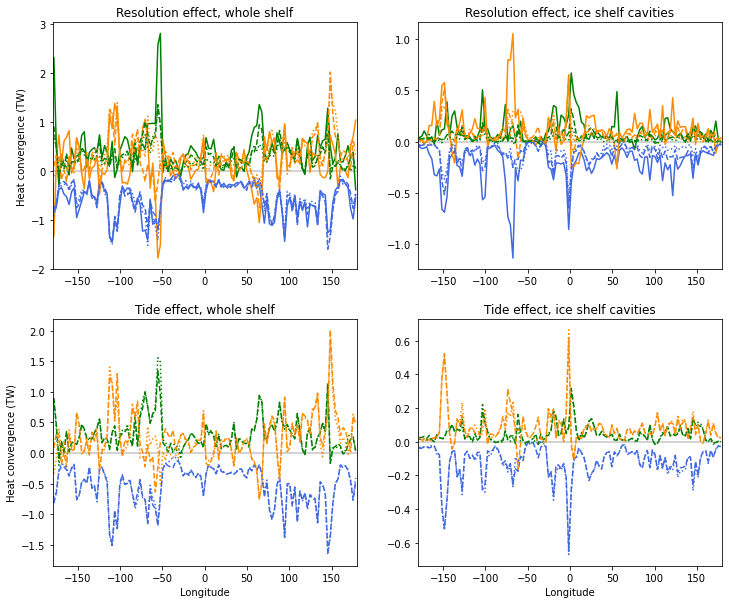

In [73]:
fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(lon_bins,(net)*0,'-', color='lightgray')
ax1.plot(lon_bins,hdiff.mean('ocean_time')*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(lon_bins,vdiff.mean('ocean_time')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(lon_bins,hadv.mean('ocean_time')*1e-12,color='darkorange',label='WAOM10 horz adv')

ax1.plot(lon_bins,w4_hdiff.mean('ocean_time')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(lon_bins,w4_vdiff.mean('ocean_time')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(lon_bins,w4_hadv.mean('ocean_time')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')

ax1.plot(lon_bins,w2_hdiff.mean('ocean_time')*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(lon_bins,w2_vdiff.mean('ocean_time')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(lon_bins,w2_hadv.mean('ocean_time')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_title('Resolution effect, whole shelf')
ax1.set_ylabel('Heat convergence (TW)')

ax1 = fig.add_subplot(2,2,2)
ax1.plot(lon_bins,(net_is)*0,'-', color='lightgray')
ax1.plot(lon_bins,hdiff_is.mean('ocean_time')*1e-12,color='green',label='WAOM10 horz diff')
ax1.plot(lon_bins,vdiff_is.mean('ocean_time')*1e-12,color='royalblue',label='WAOM10 sfc flx')
ax1.plot(lon_bins,hadv_is.mean('ocean_time')*1e-12,color='darkorange',label='WAOM10 horz adv')

ax1.plot(lon_bins,w4_hdiff_is.mean('ocean_time')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(lon_bins,w4_vdiff_is.mean('ocean_time')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(lon_bins,w4_hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')

ax1.plot(lon_bins,w2_hdiff_is.mean('ocean_time')*1e-12,':',color='green',label='WAOM2 horz diff')
ax1.plot(lon_bins,w2_vdiff_is.mean('ocean_time')*1e-12,':',color='royalblue',label='WAOM2 sfc flx')
ax1.plot(lon_bins,w2_hadv_is.mean('ocean_time')*1e-12,':',color='darkorange',label='WAOM2 horz adv')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_title('Resolution effect, ice shelf cavities')

ax1 = fig.add_subplot(2,2,3)

ax1.plot(lon_bins,(net_is)*0,'-', color='lightgray')
ax1.plot(lon_bins,w4_hdiff.mean('ocean_time')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(lon_bins,w4_vdiff.mean('ocean_time')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(lon_bins,w4_hadv.mean('ocean_time')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')

ax1.plot(lon_bins,w4nt_hdiff.mean('ocean_time')*1e-12,':',color='green',label='WAOM4-NOTIDE horz diff')
ax1.plot(lon_bins,w4nt_vdiff.mean('ocean_time')*1e-12,':',color='royalblue',label='WAOM4-NOTIDE sfc flx')
ax1.plot(lon_bins,w4nt_hadv.mean('ocean_time')*1e-12,':',color='darkorange',label='WAOM4-NOTIDE horz adv')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_title('Tide effect, whole shelf')
ax1.set_ylabel('Heat convergence (TW)')
ax1.set_xlabel('Longitude')
ax1 = fig.add_subplot(2,2,4)

ax1.plot(lon_bins,(net_is)*0,'-', color='lightgray')
ax1.plot(lon_bins,w4_hdiff_is.mean('ocean_time')*1e-12,'--',color='green',label='WAOM4 horz diff')
ax1.plot(lon_bins,w4_vdiff_is.mean('ocean_time')*1e-12,'--',color='royalblue',label='WAOM4 sfc flx')
ax1.plot(lon_bins,w4_hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='WAOM4 horz adv')

ax1.plot(lon_bins,w4nt_hdiff_is.mean('ocean_time')*1e-12,':',color='green',label='WAOM4-NOTIDE horz diff')
ax1.plot(lon_bins,w4nt_vdiff_is.mean('ocean_time')*1e-12,':',color='royalblue',label='WAOM4-NOTIDE sfc flx')
ax1.plot(lon_bins,w4nt_hadv_is.mean('ocean_time')*1e-12,':',color='darkorange',label='WAOM4-NOTIDE horz adv')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_title('Tide effect, ice shelf cavities')
ax1.set_xlabel('Longitude')

name_fig='waom10x4x4NTx2_lonbin_regional_OHBprocesses.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight',facecolor='white')


In [74]:
net

<xarray.Variable (lon_bins: 120, ocean_time: 365)>
dask.array<add, shape=(120, 365), dtype=float64, chunksize=(120, 365), chunktype=numpy.ndarray>

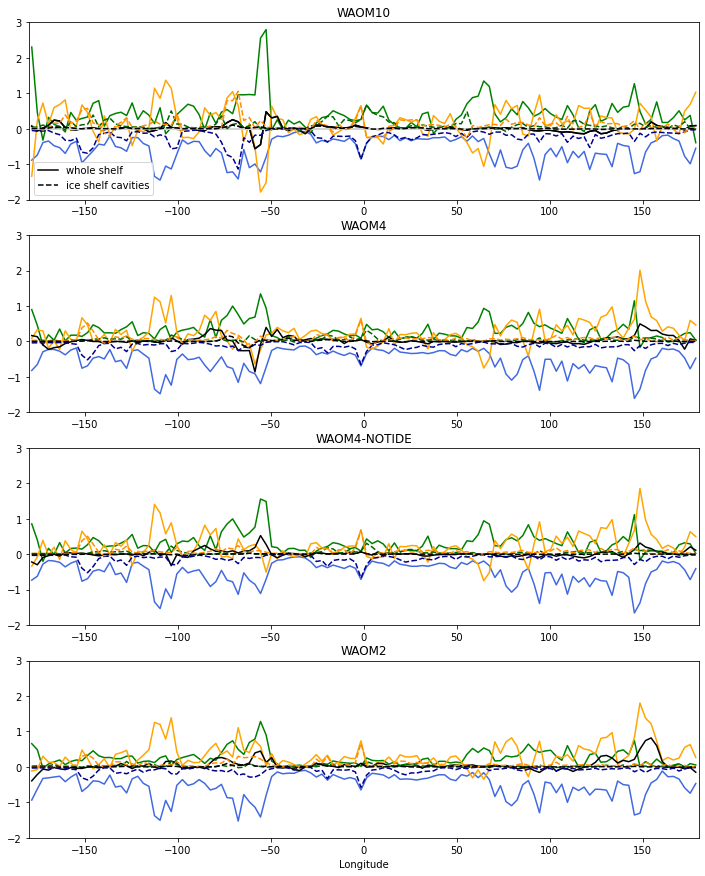

In [75]:
## 1 figure with 1 resolution (10km?), all processes + net, no cumsum. 
# Whole shelf (solid line) + cavities (dashed)
# - can we identify the driver for each "peak of OHCt/ADV/melting?
fig = plt.figure(figsize=(12,15))

ax1 = fig.add_subplot(4,1,1)
ax1.plot(lon_bins,(net)*0,'-', color='lightgray')
ax1.plot(lon_bins,net.mean('ocean_time')*1e-12,'-',color='k',label='whole shelf')
ax1.plot(lon_bins,net_is.mean('ocean_time')*1e-12,'--',color='k',label='ice shelf cavities')
ax1.legend(loc='lower left')
ax1.plot(lon_bins,hdiff.mean('ocean_time')*1e-12,'-',color='green',label='horz diff')
ax1.plot(lon_bins,vdiff.mean('ocean_time')*1e-12,'-',color='royalblue',label='sfc flx')
ax1.plot(lon_bins,hadv.mean('ocean_time')*1e-12,'-',color='orange',label='horz adv')
ax1.plot(lon_bins,net.mean('ocean_time')*1e-12,'-',color='k',label='net')
ax1.plot(lon_bins,(net_is)*0,'-', color='lightgray')
ax1.plot(lon_bins,hdiff_is.mean('ocean_time')*1e-12,'--',color='darkgreen',label='horz diff')
ax1.plot(lon_bins,vdiff_is.mean('ocean_time')*1e-12,'--',color='darkblue',label='sfc flx')
ax1.plot(lon_bins,hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='horz adv')
ax1.plot(lon_bins,net_is.mean('ocean_time')*1e-12,'--',color='k',label='net')
ax1.set_title('WAOM10')
ax1.set_xlim(-180,180)
ax1.set_ylim(-2,3)

ax1 = fig.add_subplot(4,1,2)
ax1.plot(lon_bins,w4_hdiff.mean('ocean_time')*1e-12,'-',color='green',label='horz diff')
ax1.plot(lon_bins,w4_vdiff.mean('ocean_time')*1e-12,'-',color='royalblue',label='sfc flx')
ax1.plot(lon_bins,w4_hadv.mean('ocean_time')*1e-12,'-',color='orange',label='horz adv')
ax1.plot(lon_bins,w4_net.mean('ocean_time')*1e-12,'-',color='k',label='horz adv')
ax1.plot(lon_bins,w4_hdiff_is.mean('ocean_time')*1e-12,'--',color='darkgreen',label='horz diff')
ax1.plot(lon_bins,w4_vdiff_is.mean('ocean_time')*1e-12,'--',color='darkblue',label='sfc flx')
ax1.plot(lon_bins,w4_hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='horz adv')
ax1.plot(lon_bins,w4_net_is.mean('ocean_time')*1e-12,'--',color='k',label='net')
ax1.set_title('WAOM4')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_ylim(-2,3)

ax1 = fig.add_subplot(4,1,3)
ax1.plot(lon_bins,w4nt_hdiff.mean('ocean_time')*1e-12,'-',color='green',label='horz diff')
ax1.plot(lon_bins,w4nt_vdiff.mean('ocean_time')*1e-12,'-',color='royalblue',label='sfc flx')
ax1.plot(lon_bins,w4nt_hadv.mean('ocean_time')*1e-12,'-',color='orange',label='horz adv')
ax1.plot(lon_bins,w4nt_net.mean('ocean_time')*1e-12,'-',color='k',label='horz adv')
ax1.plot(lon_bins,w4nt_hdiff_is.mean('ocean_time')*1e-12,'--',color='darkgreen',label='horz diff')
ax1.plot(lon_bins,w4nt_vdiff_is.mean('ocean_time')*1e-12,'--',color='darkblue',label='sfc flx')
ax1.plot(lon_bins,w4nt_hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='horz adv')
ax1.plot(lon_bins,w4nt_net_is.mean('ocean_time')*1e-12,'--',color='k',label='net')
ax1.set_title('WAOM4-NOTIDE')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_ylim(-2,3)

ax1 = fig.add_subplot(4,1,4)
ax1.plot(lon_bins,w2_hdiff.mean('ocean_time')*1e-12,'-',color='green',label='horz diff')
ax1.plot(lon_bins,w2_vdiff.mean('ocean_time')*1e-12,'-',color='royalblue',label='sfc flx')
ax1.plot(lon_bins,w2_hadv.mean('ocean_time')*1e-12,'-',color='orange',label='horz adv')
ax1.plot(lon_bins,w2_net.mean('ocean_time')*1e-12,'-',color='k',label='horz adv')
ax1.plot(lon_bins,w2_hdiff_is.mean('ocean_time')*1e-12,'--',color='darkgreen',label='horz diff')
ax1.plot(lon_bins,w2_vdiff_is.mean('ocean_time')*1e-12,'--',color='darkblue',label='sfc flx')
ax1.plot(lon_bins,w2_hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='horz adv')
ax1.plot(lon_bins,w2_net_is.mean('ocean_time')*1e-12,'--',color='k',label='net')
ax1.set_title('WAOM2')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_ylim(-2,3)
ax1.set_xlabel('Longitude')


name_fig='waom10x4x2_lonbin_regional_OHBprocesses.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight',facecolor='white')


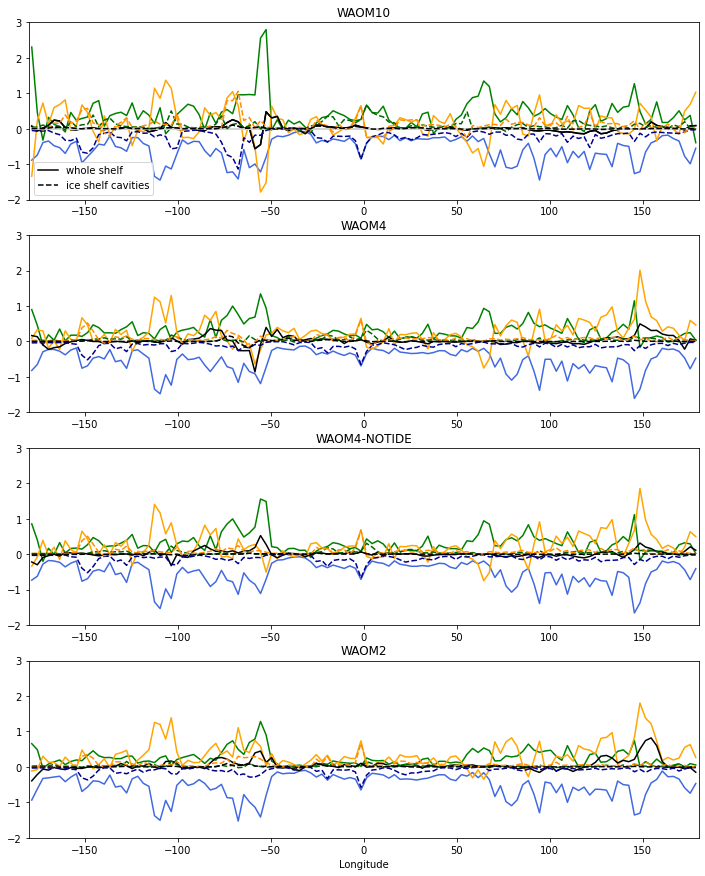

In [76]:
## 1 figure with 1 resolution (10km?), all processes + net, no cumsum. 
# Whole shelf (solid line) + cavities (dashed)
# - can we identify the driver for each "peak of OHCt/ADV/melting?
fig = plt.figure(figsize=(12,15))

ax1 = fig.add_subplot(4,1,1)
ax1.plot(lon_bins,(net)*0,'-', color='lightgray')
ax1.plot(lon_bins,net.mean('ocean_time')*1e-12,'-',color='k',label='whole shelf')
ax1.plot(lon_bins,net_is.mean('ocean_time')*1e-12,'--',color='k',label='ice shelf cavities')
ax1.legend(loc='lower left')
ax1.plot(lon_bins,hdiff.mean('ocean_time')*1e-12,'-',color='green',label='horz diff')
ax1.plot(lon_bins,vdiff.mean('ocean_time')*1e-12,'-',color='royalblue',label='sfc flx')
ax1.plot(lon_bins,hadv.mean('ocean_time')*1e-12,'-',color='orange',label='horz adv')
ax1.plot(lon_bins,net.mean('ocean_time')*1e-12,'-',color='k',label='net')
ax1.plot(lon_bins,(net_is)*0,'-', color='lightgray')
ax1.plot(lon_bins,hdiff_is.mean('ocean_time')*1e-12,'--',color='darkgreen',label='horz diff')
ax1.plot(lon_bins,vdiff_is.mean('ocean_time')*1e-12,'--',color='darkblue',label='sfc flx')
ax1.plot(lon_bins,hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='horz adv')
ax1.plot(lon_bins,net_is.mean('ocean_time')*1e-12,'--',color='k',label='net')
ax1.set_title('WAOM10')
ax1.set_xlim(-180,180)
ax1.set_ylim(-2,3)

ax1 = fig.add_subplot(4,1,2)
ax1.plot(lon_bins,w4_hdiff.mean('ocean_time')*1e-12,'-',color='green',label='horz diff')
ax1.plot(lon_bins,w4_vdiff.mean('ocean_time')*1e-12,'-',color='royalblue',label='sfc flx')
ax1.plot(lon_bins,w4_hadv.mean('ocean_time')*1e-12,'-',color='orange',label='horz adv')
ax1.plot(lon_bins,w4_net.mean('ocean_time')*1e-12,'-',color='k',label='horz adv')
ax1.plot(lon_bins,w4_hdiff_is.mean('ocean_time')*1e-12,'--',color='darkgreen',label='horz diff')
ax1.plot(lon_bins,w4_vdiff_is.mean('ocean_time')*1e-12,'--',color='darkblue',label='sfc flx')
ax1.plot(lon_bins,w4_hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='horz adv')
ax1.plot(lon_bins,w4_net_is.mean('ocean_time')*1e-12,'--',color='k',label='net')
ax1.set_title('WAOM4')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_ylim(-2,3)

ax1 = fig.add_subplot(4,1,3)
ax1.plot(lon_bins,w4nt_hdiff.mean('ocean_time')*1e-12,'-',color='green',label='horz diff')
ax1.plot(lon_bins,w4nt_vdiff.mean('ocean_time')*1e-12,'-',color='royalblue',label='sfc flx')
ax1.plot(lon_bins,w4nt_hadv.mean('ocean_time')*1e-12,'-',color='orange',label='horz adv')
ax1.plot(lon_bins,w4nt_net.mean('ocean_time')*1e-12,'-',color='k',label='horz adv')
ax1.plot(lon_bins,w4nt_hdiff_is.mean('ocean_time')*1e-12,'--',color='darkgreen',label='horz diff')
ax1.plot(lon_bins,w4nt_vdiff_is.mean('ocean_time')*1e-12,'--',color='darkblue',label='sfc flx')
ax1.plot(lon_bins,w4nt_hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='horz adv')
ax1.plot(lon_bins,w4nt_net_is.mean('ocean_time')*1e-12,'--',color='k',label='net')
ax1.set_title('WAOM4-NOTIDE')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_ylim(-2,3)

ax1 = fig.add_subplot(4,1,4)
ax1.plot(lon_bins,w2_hdiff.mean('ocean_time')*1e-12,'-',color='green',label='horz diff')
ax1.plot(lon_bins,w2_vdiff.mean('ocean_time')*1e-12,'-',color='royalblue',label='sfc flx')
ax1.plot(lon_bins,w2_hadv.mean('ocean_time')*1e-12,'-',color='orange',label='horz adv')
ax1.plot(lon_bins,w2_net.mean('ocean_time')*1e-12,'-',color='k',label='horz adv')
ax1.plot(lon_bins,w2_hdiff_is.mean('ocean_time')*1e-12,'--',color='darkgreen',label='horz diff')
ax1.plot(lon_bins,w2_vdiff_is.mean('ocean_time')*1e-12,'--',color='darkblue',label='sfc flx')
ax1.plot(lon_bins,w2_hadv_is.mean('ocean_time')*1e-12,'--',color='darkorange',label='horz adv')
ax1.plot(lon_bins,w2_net_is.mean('ocean_time')*1e-12,'--',color='k',label='net')
ax1.set_title('WAOM2')
# ax1.legend(loc='lower left')
ax1.set_xlim(-180,180)
ax1.set_ylim(-2,3)
ax1.set_xlabel('Longitude')


name_fig='waom10x4x2_lonbin_regional_OHBprocesses.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight',facecolor='white')


In [77]:
### test mask_iceshelf effect:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
contour_masked_above_CF_tst = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)
mask_iceshelf = ma.masked_where(contour_masked_above_CF!=-1000, np.ones(h.shape))
mask_outiceshelf = ma.masked_where(contour_masked_above_CF==-1000, np.ones(h.shape))

contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
mask_shelf = ma.masked_where(contour_masked_above==-1000, np.ones(h.shape))

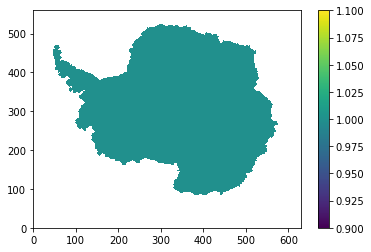

In [78]:
# plt.pcolormesh(mask_iceshelf)
plt.pcolormesh(mask_outiceshelf)
plt.colorbar()


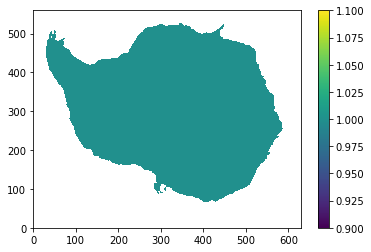

In [79]:
plt.pcolormesh(mask_shelf)
plt.colorbar()


#### section to test volume-integrating and save in a netcdf file

In [80]:
files_path + "WAOM10_OHB_lonbins_temp_hadv_vint_daily"

'/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/WAOM10_OHB_lonbins_temp_hadv_vint_daily'

In [81]:
%%time

tlen=365
# heat tendency due to horizontal advection:
temp_hadv_int = np.empty((tlen))
temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
    temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
    temp_hadv_vint_masked =  ma.masked_where(condition1, temp_hadv_vint)
    temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area
    temp_hadv_int[mm] = np.nansum(np.nansum(temp_hadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 3min 14s, sys: 2min 23s, total: 5min 38s
Wall time: 8min 48s


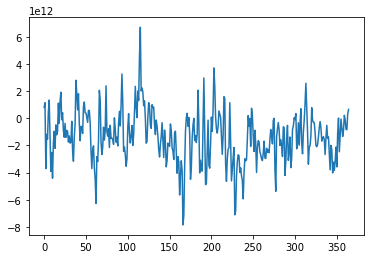

In [82]:
plt.plot(temp_hadv_int)

In [83]:
lon_bin_midpts = np.arange(-178.5,180,3)


In [84]:
temp_hadv_int.shape

(365,)

In [85]:
# saving into a netcdf file:
months=np.arange(0,365)*(1/30.41667)

coordinatesC=dict(ocean_time=months)
temp_hadv_int_xr = xr.DataArray(temp_hadv_int, coords = coordinatesC, dims = ['ocean_time'])

# for py file:
# lon_bin_limits = np.arange(-177,180,3)
# lon_bin_midpts = np.arange(-178.5,180,3)
# coordinatesC=dict(ocean_time=months, lon_bins=lon_bin_midpts)
# temp_hadv_int_xr = xr.DataArray(temp_hadv_int, coords = coordinatesC, dims = ['ocean_time','lon_bins'])

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
temp_hadv_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1lonbin_temp_hadv_vint_daily', mode='w', format="NETCDF4")


In [86]:
temp_hadv

<xarray.DataArray 'temp_hadv' (ocean_time: 365, s_rho: 31, eta_rho: 560,
                               xi_rho: 630)>
dask.array<concatenate, shape=(365, 31, 560, 630), dtype=float32, chunksize=(5, 31, 280, 630), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
    x_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(560, 630), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(560, 630), meta=np.ndarray>
  * ocean_time  (ocean_time) float64 5.992e+08 5.993e+08 ... 6.306e+08 6.307e+08
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  potential temperature, horizontal advection term
    units:      Celsius second-1
    time:       ocean_time
    field:      temp_hadv, scalar, series

In [87]:
mask_LonBins

<xarray.Variable (time: 120, y: 560, x: 630)>
[42336000 values with dtype=float64]

In [88]:
## example for vert.+horz. integral:

# %%time
# # 4. heat tendency due to horizontal advection:
# temp_hadv_int = np.empty((tlen))
# temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
# for mm in np.arange(0,tlen):
# # - multplying by dz:
#     temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
#     temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
#     temp_hadv_vint_masked =  ma.masked_where(combined_condition, temp_hadv_vint)
#     temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area
#     temp_hadv_int[mm] = np.nansum(np.nansum(temp_hadv_vol[mm,:],axis=1), axis=0)*Cp*rho0
